# Simulaciones

In [1]:
from lectura_datos import *
import regionalizacion as reg
import matplotlib.pyplot as plt
import pickle 
import copy

%matplotlib inline
%load_ext autoreload
%autoreload 2

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_FileGDB.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_FileGDB.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_MSSQLSpatial.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_MSSQLSpatial.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_OCI.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_OCI.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_PG.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_PG.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Fil

El mes desde el cuál todos los dptos tienen al menos 1 contagiado es: 2021-01


In [2]:
codiprov.groupby('provincia').describe()

regiones = {'noroeste' : ('Jujuy','Salta','Tucumán','Santiago del Estero','Catamarca'),
            'noreste'  : ('Formosa', 'Chaco', 'Misiones','Corrientes','Santa Fe','Entre Ríos'),
            'cuyo' : ('La Rioja','San Juan','Mendoza','San Luis'),
            'pampeana' : ('Córdoba', 'La Pampa', 'Buenos Aires','Ciudad Autónoma de Buenos Aires' ),
            'patagonia' : ('Neuquén', 'Río Negro', 'Chubut', 'Santa Cruz', 'Tierra del Fuego')    
    }


lista_regiones = []
errores = []
for i in range(len(codiprov)):
    prov = codiprov.iloc[i].provincia
    j = 1
    pertenece = False
    for k in regiones.keys():
        l = regiones[k]
        if prov in l:
            lista_regiones.append(j)
            pertenece = True
        else:
        
            pass
        j += 1
    if pertenece == False:
        errores.append(codiprov.iloc[i]) 


cov =  covid.loc[pd.IndexSlice[:,'2021-01'],:].copy()
cov['reg'] = lista_regiones

var = cov.reg.map({1:0.0001,2:0.001,3:0.1, 4:0.3, 5:0.7})* cov.personas


<AxesSubplot:>

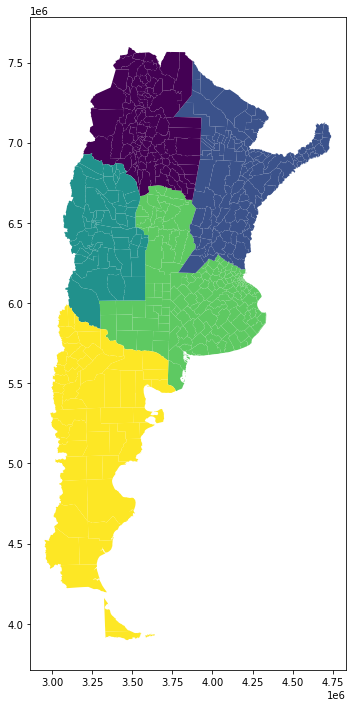

In [3]:
cov.plot('reg', figsize = (15,12))

In [4]:
var = cov.reg.map({1:0.0001,2:0.001,3:0.1, 4:0.3, 5:0.7})* cov.personas
var.head()
#transformo la variable en un GeoDataFrame para seguir trabajando y le agrego la variable personas que sería la variable poblacional
var = pd.concat([var,cov.personas], axis = 1)
var = var.rename(columns = {0:'var1'})
var = var.droplevel('mes')
var = gpd.GeoDataFrame(var, geometry = geo)
var.head()

var1  personas                                           geometry
link                                                                      
2001  61765.8    205886  POLYGON ((4200350.769 6147470.664, 4201101.267...
2002  47379.6    157932  POLYGON ((4198043.775 6148577.659, 4198111.775...
2003  56261.1    187537  POLYGON ((4198450.276 6145157.669, 4198456.277...
2004  65473.5    218245  POLYGON ((4201672.770 6142869.179, 4201695.770...
2005  53701.5    179005  POLYGON ((4196342.782 6145516.166, 4196373.783...

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
pipe = Pipeline([('standard', StandardScaler())#,
                 #('normalizer', Normalizer('l1'))
                 ])
# El pipeline sirve para transformar los datos, en este caso los vamos a estandarizar primero y luego normalizamos esos datos

In [6]:
sim1 = reg.entorno(var, ['var1'],'personas', pipe)

C:\Anaconda3\envs\covid2\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


convertir a panel los datos


Este entorno posee los datos necesarios para trabajar, tiene el data frame 

In [7]:
sim1.df.head()

var1  personas                                           geometry
link                                                                      
2001  61765.8    205886  POLYGON ((4200350.769 6147470.664, 4201101.267...
2002  47379.6    157932  POLYGON ((4198043.775 6148577.659, 4198111.775...
2003  56261.1    187537  POLYGON ((4198450.276 6145157.669, 4198456.277...
2004  65473.5    218245  POLYGON ((4201672.770 6142869.179, 4201695.770...
2005  53701.5    179005  POLYGON ((4196342.782 6145516.166, 4196373.783...

Se puede convertir el data frame a panel cuando sea necesari

In [8]:
sim1.convertir_a_panel(peris = 1, variables = 1).head()

var1  personas
link                        
2001 var1  61765.8  205886.0
2002 var1  47379.6  157932.0
2003 var1  56261.1  187537.0
2004 var1  65473.5  218245.0
2005 var1  53701.5  179005.0

Tambien incluye las coordenadas de los centroides ya calculadas


In [9]:
sim1.coord_centroides

array([[4200374.5599913 , 6144302.79532681],
       [4198398.67483647, 6146700.15001771],
       [4197433.50946191, 6143646.47341226],
       ...,
       [3565010.72254006, 7037226.82023455],
       [3375047.37192866, 4011389.98613591],
       [3452392.50599493, 3931746.67398943]])

Y se calculan las matrices queen, rook y w_knn de 6. Por defecto se asigna para trabajar la w_knn

In [10]:
[sim1.W_queen, sim1.W_rook, sim1.W_knn]

El metodo procesar datos agrega las variables por separado ajustadas de acuerdo al pipeline, y además permite calcular el I de Moran para todas las variables y el promedio de vecinos. Luego se pueden obtener los datos que se necesiten para aplicarle una metodología de clustering

In [11]:
sim1.procesar_datos()
sim1.retornar_dfs([['var1','personas','coord','I_moran','prom_vecinos']])

[array([[ 1.06233026,  0.87066425,  1.04060559, ...,  0.36635665,
          1.37982181,  1.17584375],
        [ 0.72783543,  0.54818873,  1.03543585, ...,  0.16514103,
          1.46107208,  1.26104357],
        [ 0.93433998,  0.74727301,  1.03291058, ...,  0.293133  ,
          1.41091121,  1.2084444 ],
        ...,
        [-0.37361735, -0.00899172, -0.62176967, ..., -0.25533033,
         -0.55922173,  0.95001644],
        [ 0.76619508, -0.04284378, -1.11879256, ..., -0.23935953,
          0.28837759, -0.47688594],
        [ 0.55321044, -0.130843  , -0.91642562, ..., -0.21897803,
          0.34011249, -0.45363606]])]

Con el método "agregar_metodo" se pueden ir agregando metodologías de clustering para trabjar. Estas se agregan con un diccionario de parámetros que permite ir recorriendo varias alternativas y un diccionario de metricas que va permitir al algoritmo quedarse con la que persente mejores metricas.

In [12]:
sim1.metric.obtener_panel(periodos = 1, variables = 1)
param = {'n_clusters' : [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]} #se crean los distintos parametros para probar, en este caso solo de cantidad de grupos
metricas = {'hg': sim1.metric.Hg_relat, 'ind lq': sim1.metric.indice_lq} # se crean las metricas. En este caso las que provienen del LQ y es importante que salgan del entorno así buscan bien los datos

from sklearn.cluster import KMeans, AgglomerativeClustering

sim1.agregar_metodo('km', KMeans(), param, metricas)
sim1.agregar_metodo('aglo', AgglomerativeClustering(), param, metricas)

## Cálculos

In [13]:
sim1.calcular_metodo('km', [['var1','personas']]) #se pone el nombre del metodo y las variables a utilizar en una lista de listas si se quiere todas juntas. Siempre se agregan coordenadas

hg    ind lq
9  0.55507  0.963636

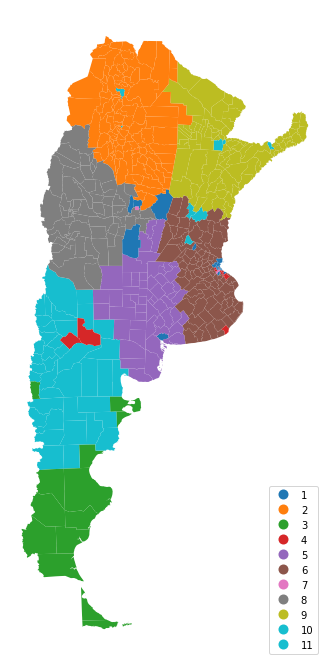

In [14]:
sim1.mapa('km')

La información que le está pasando es la variable y la población por separado y se agregan las coordenadas. Como se ve, no se acerca mucho al valor real, aunque si tiene buenos rdos debido a que tiene muchos grupos. 

Ahora se puede seguir probando diferentes modelos que van a ir guardandose dentro del entorno que se ha creado

In [15]:
sim1.calcular_metodo('aglo', [['var1','personas']]) #jerárquico con variable y personas separado
sim1.calcular_metodo('aglo', [['var1','personas', 'prom_vecinos']]) #jerárquico con I de moran y promedio de vecinos
sim1.calcular_metodo('km', [['var1','personas', 'prom_vecinos']]) # kmeans con I_moran y prom de vecinos

hg    ind lq
9  0.472137  0.927273

In [16]:
# los distintos resultados ahora se guardan en diccionarios, uno que muestra el método y las columnas qeu se usaron.

sim1.met_desc

{'km': {1: {'columnas': [['var1', 'personas']], 'ae': False},
  2: {'columnas': [['var1', 'personas', 'prom_vecinos']], 'ae': False}},
 'aglo': {1: {'columnas': [['var1', 'personas']], 'ae': False},
  2: {'columnas': [['var1', 'personas', 'prom_vecinos']], 'ae': False}}}

In [17]:
# El atributo metodos_rdos tiene guardado todos los metodos que se han usado hasta ahora y se puede consultar las metricas o los grupos que forman. 
def resultados(entorno):
    rdos = []
    for m in entorno.metodos_rdos.keys():
        r = []
        for n in entorno.metodos_rdos[m].keys():
            res = (entorno.metodos_rdos[m][n].best_metrics_).copy()
            res['Metodo'] = m
            res['Vers'] = n
            r.append(res[['Metodo','Vers','hg','ind lq']])
        rdos.extend(r)

    return pd.concat(rdos, axis = 0)
resultados(sim1)

Metodo  Vers        hg    ind lq
9     km     1  0.555070  0.963636
9     km     2  0.472137  0.927273
4   aglo     1 -0.186157  1.000000
4   aglo     2  0.821534  1.000000

Al parecer el metodo jerárquico con las columnas de los datos solamente parece ser el mejor. Para consultarlo con la función mapa se puede consultar

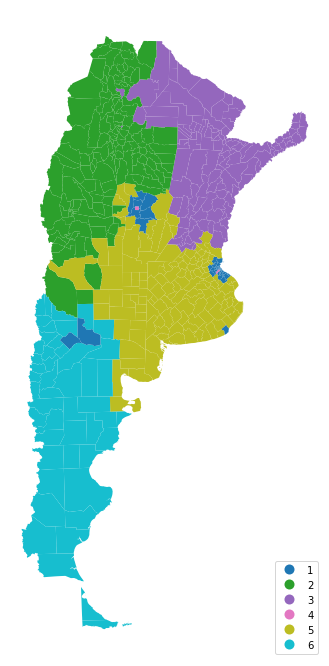

In [18]:
sim1.mapa('aglo', 2)

In [19]:
sim1.calcular_metodo('aglo', [['var1','personas', 'prom_vecinos', 'I_Moran']]) 

hg  ind lq
2  0.664884     1.0

### Interacciones de variables

Si usamos el método interacciones se calcula la interacción entre las variables ,el I de Moran respectivo y el promedio de vecinos

In [20]:
sim1.interacciones()
sim1.calcular_metodo('km', ['interac'])
sim1.calcular_metodo('km', [['interac','interac_prom_vec']])
sim1.calcular_metodo('aglo', ['interac'])
sim1.calcular_metodo('aglo', [['interac','interac_prom_vec']])
resultados(sim1)

Metodo  Vers        hg    ind lq
9     km     1  0.555070  0.963636
9     km     2  0.472137  0.927273
0     km     3  0.560372  1.000000
0     km     4  0.560372  1.000000
4   aglo     1 -0.186157  1.000000
4   aglo     2  0.821534  1.000000
2   aglo     3  0.664884  1.000000
0   aglo     4  0.560372  1.000000
0   aglo     5  0.560372  1.000000

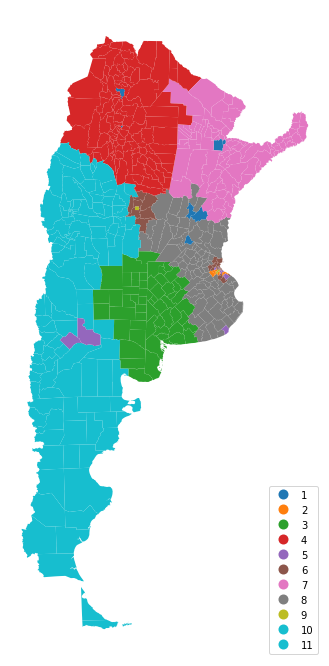

In [21]:
# podemos ver que kmeans de las interacciones da mejores resultados en indicadores que sin ellas, aunque sigue siendo mejor el jerárquico
sim1.mapa('km', 2)

In [22]:
param_aglo = copy.copy(param)
param_aglo['connectivity'] = [sim1.W.sparse]
sim1.agregar_metodo('aglo_esp', AgglomerativeClustering(), param_aglo, metricas)
sim1.calcular_metodo('aglo_esp', [['var1','personas']])
sim1.calcular_metodo('aglo_esp', [['var1','personas', 'prom_vecinos']])
sim1.calcular_metodo('aglo_esp', [['var1','personas', 'prom_vecinos','I_Moran']])
sim1.calcular_metodo('aglo_esp', [['interac']])
sim1.calcular_metodo('aglo_esp', [['interac','interac_prom_vec']])
#sim1.calcular_metodo('aglo_esp', [['interac','interac_prom_vec','interac_Imoran']])
resultados(sim1)

Metodo  Vers        hg    ind lq
9         km     1  0.555070  0.963636
9         km     2  0.472137  0.927273
0         km     3  0.560372  1.000000
0         km     4  0.560372  1.000000
4       aglo     1 -0.186157  1.000000
4       aglo     2  0.821534  1.000000
2       aglo     3  0.664884  1.000000
0       aglo     4  0.560372  1.000000
0       aglo     5  0.560372  1.000000
8   aglo_esp     1  0.994294  0.888889
9   aglo_esp     2  0.975209  0.854545
3   aglo_esp     3  0.822086  0.900000
18  aglo_esp     4  0.990020  0.731579
14  aglo_esp     5  0.953036  0.616667

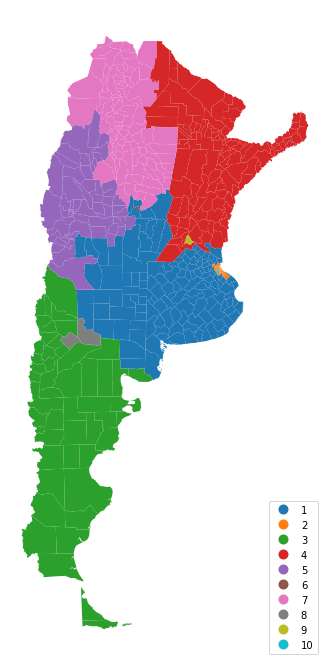

In [23]:
sim1.mapa('aglo_esp',1)

De acuerdo a como armamos los datos, sabemos que la verdadera interacción entre las variables es la  variable dividia por la población. La podemos agregar para luego calcular los clustering con esa variable nueva

In [24]:
sim1.agregar_data('porc',(sim1.df.var1/sim1.df.personas).values.reshape(-1,1), ajustar = False) 
sim1.calcular_metodo('km', ['porc'])
sim1.calcular_metodo('aglo', ['porc'])
resultados(sim1)

Metodo  Vers        hg    ind lq
9         km     1  0.555070  0.963636
9         km     2  0.472137  0.927273
0         km     3  0.560372  1.000000
0         km     4  0.560372  1.000000
9         km     5  0.960283  0.963636
4       aglo     1 -0.186157  1.000000
4       aglo     2  0.821534  1.000000
2       aglo     3  0.664884  1.000000
0       aglo     4  0.560372  1.000000
0       aglo     5  0.560372  1.000000
5       aglo     6  0.801573  1.000000
8   aglo_esp     1  0.994294  0.888889
9   aglo_esp     2  0.975209  0.854545
3   aglo_esp     3  0.822086  0.900000
18  aglo_esp     4  0.990020  0.731579
14  aglo_esp     5  0.953036  0.616667

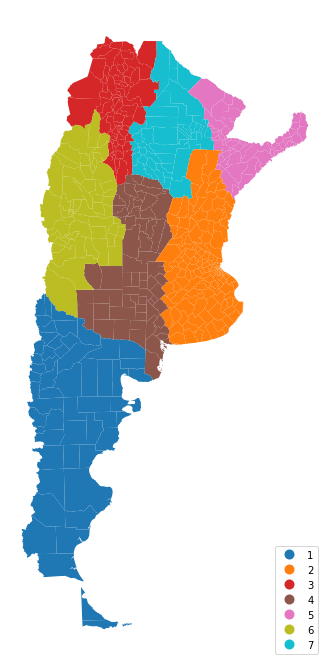

In [25]:
sim1.mapa('aglo',6)

D:\Archivos\Codigos\COVID\regionalizacion.py:103: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  model.fit(data)
D:\Archivos\Codigos\COVID\regionalizacion.py:103: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  model.fit(data)
D:\Archivos\Codigos\COVID\regionalizacion.py:103: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  model.fit(data)
D:\Archivos\Codigos\COVID\regionalizacion.py:103: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  model.fit(data)
D:\Archivos\Codigos\COVID\regionalizacion.py:103: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  model.fit(data)
D:\Archivos\Codigos\COVID\reg

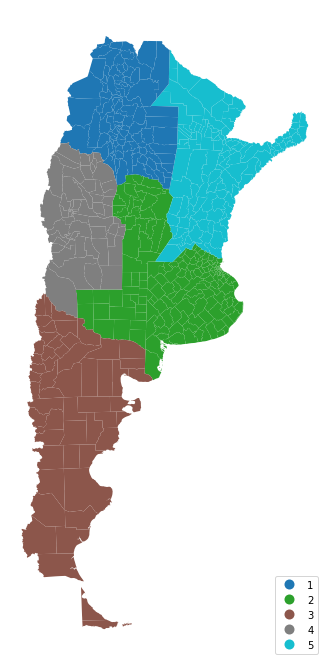

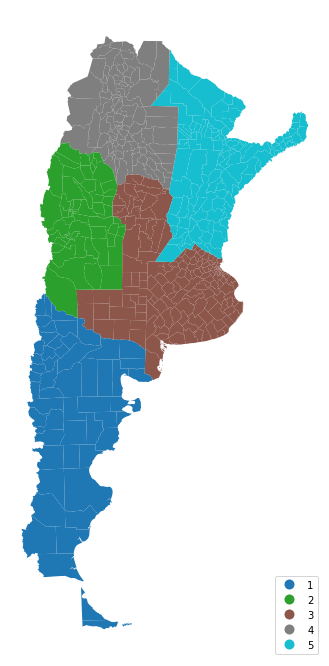

(None, None)

In [26]:
# probamos sin centroides
sim1.calcular_metodo('km', ['porc'], centroides = False)
sim1.calcular_metodo('aglo', ['porc'], centroides = False)
sim1.mapa('km'), sim1.mapa('aglo')

En el caso de que solo se pasa el porcentaje, el método llega de manera perfecta al resultado buscado 

In [27]:
sim1.calcular_metodo('aglo_esp', ['porc'])
sim1.calcular_metodo('aglo_esp', ['porc'], centroides = False)
resultados(sim1)

Metodo  Vers        hg    ind lq
9         km     1  0.555070  0.963636
9         km     2  0.472137  0.927273
0         km     3  0.560372  1.000000
0         km     4  0.560372  1.000000
9         km     5  0.960283  0.963636
3         km     6  1.000000  1.000000
4         km     6  1.000000  1.000000
5         km     6  1.000000  1.000000
6         km     6  1.000000  1.000000
7         km     6  1.000000  1.000000
8         km     6  1.000000  1.000000
9         km     6  1.000000  1.000000
11        km     6  1.000000  1.000000
12        km     6  1.000000  1.000000
13        km     6  1.000000  1.000000
14        km     6  1.000000  1.000000
15        km     6  1.000000  1.000000
16        km     6  1.000000  1.000000
17        km     6  1.000000  1.000000
18        km     6  1.000000  1.000000
4       aglo     1 -0.186157  1.000000
4       aglo     2  0.821534  1.000000
2       aglo     3  0.664884  1.000000
0       aglo     4  0.560372  1.000000
0       aglo     5  0.560372  1.000000
5       aglo     6  0.801573  1.000000
3       aglo     7  1.000000  1.000000
8   aglo_esp     1  0.994294  0.888889
9   aglo_esp     2  0.975209  0.854545
3   aglo_esp     3  0.822086  0.900000
18  aglo_esp     4  0.990020  0.731579
14  aglo_esp     5  0.953036  0.616667
7   aglo_esp     6  0.999916  0.916667
3   aglo_esp     7  1.000000  1.000000

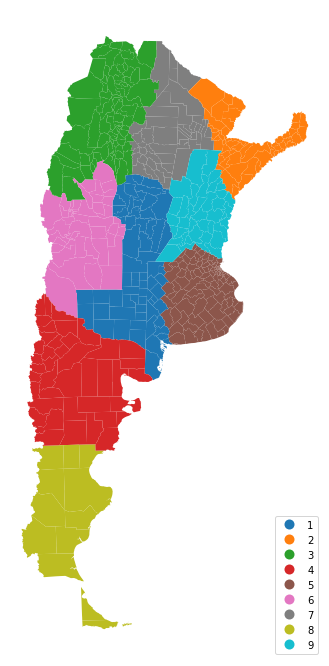

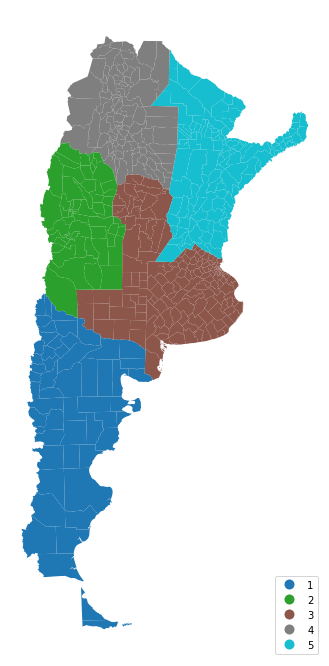

(None, None)

In [28]:
sim1.mapa('aglo_esp',6),sim1.mapa('aglo_esp',7)

### Autoencoders

In [29]:
np.random.seed(5656)
#para calcular sobre los autoencoders hay que agregar la variable "ae" y si se quiere cambiar el número de encoders por defecto en 2
sim1.calcular_metodo('km', [['var1','personas']], ae = True, n_encoders = 1)
sim1.calcular_metodo('aglo', [['var1','personas']], ae = True, n_encoders = 1)
sim1.calcular_metodo('km', [['var1','personas'],['I_Moran']], ae = True, n_encoders = 1)
sim1.calcular_metodo('aglo', [['var1','personas'],['I_Moran']], ae = True, n_encoders = 1)
sim1.calcular_metodo('km', [['var1','personas'],['prom_vecinos']], ae = True, n_encoders = 1)
sim1.calcular_metodo('aglo', [['var1','personas'],['prom_vecinos']], ae = True, n_encoders = 1)
sim1.calcular_metodo('km', [['var1','personas'],['I_Moran','prom_vecinos']], ae = True, n_encoders = 1)
sim1.calcular_metodo('aglo', [['var1','personas'],['I_Moran','prom_vecinos']], ae = True, n_encoders = 1)
resultados(sim1)

Metodo  Vers        hg    ind lq
9         km     1  0.555070  0.963636
9         km     2  0.472137  0.927273
0         km     3  0.560372  1.000000
0         km     4  0.560372  1.000000
9         km     5  0.960283  0.963636
3         km     6  1.000000  1.000000
4         km     6  1.000000  1.000000
5         km     6  1.000000  1.000000
6         km     6  1.000000  1.000000
7         km     6  1.000000  1.000000
8         km     6  1.000000  1.000000
9         km     6  1.000000  1.000000
11        km     6  1.000000  1.000000
12        km     6  1.000000  1.000000
13        km     6  1.000000  1.000000
14        km     6  1.000000  1.000000
15        km     6  1.000000  1.000000
16        km     6  1.000000  1.000000
17        km     6  1.000000  1.000000
18        km     6  1.000000  1.000000
10        km     7  0.962187  0.969697
12        km     8  0.966931  0.978022
9         km     9  0.838077  0.945455
9         km    10  0.922775  0.981818
4       aglo     1 -0.186157  1.000000
4       aglo     2  0.821534  1.000000
2       aglo     3  0.664884  1.000000
0       aglo     4  0.560372  1.000000
0       aglo     5  0.560372  1.000000
5       aglo     6  0.801573  1.000000
3       aglo     7  1.000000  1.000000
10      aglo     8  0.920084  0.984848
10      aglo     9  0.920084  0.984848
10      aglo    10  0.920084  0.984848
10      aglo    11  0.920084  0.984848
8   aglo_esp     1  0.994294  0.888889
9   aglo_esp     2  0.975209  0.854545
3   aglo_esp     3  0.822086  0.900000
18  aglo_esp     4  0.990020  0.731579
14  aglo_esp     5  0.953036  0.616667
7   aglo_esp     6  0.999916  0.916667
3   aglo_esp     7  1.000000  1.000000

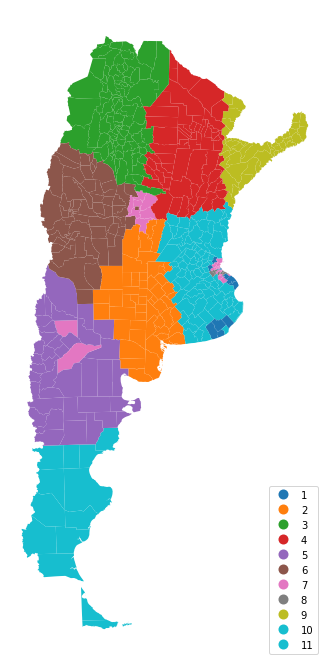

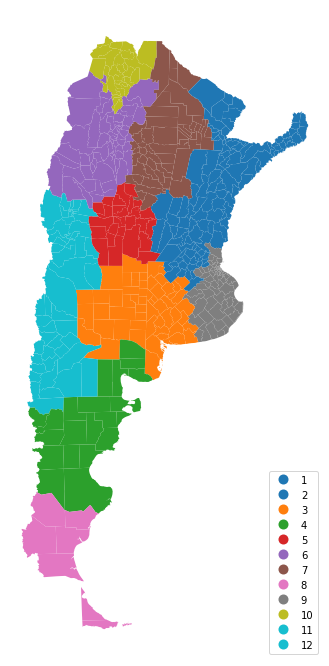

(None, None)

In [30]:
sim1.mapa('km',9),sim1.mapa('aglo',11)

In [31]:
sim1.met_desc

{'km': {1: {'columnas': [['var1', 'personas']], 'ae': False},
  2: {'columnas': [['var1', 'personas', 'prom_vecinos']], 'ae': False},
  3: {'columnas': ['interac'], 'ae': False},
  4: {'columnas': [['interac', 'interac_prom_vec']], 'ae': False},
  5: {'columnas': ['porc'], 'ae': False},
  6: {'columnas': ['porc'], 'ae': False},
  7: {'columnas': [['var1', 'personas']], 'ae': True},
  8: {'columnas': [['var1', 'personas'], ['I_Moran']], 'ae': True},
  9: {'columnas': [['var1', 'personas'], ['prom_vecinos']], 'ae': True},
  10: {'columnas': [['var1', 'personas'], ['I_Moran', 'prom_vecinos']],
   'ae': True}},
 'aglo': {1: {'columnas': [['var1', 'personas']], 'ae': False},
  2: {'columnas': [['var1', 'personas', 'prom_vecinos']], 'ae': False},
  3: {'columnas': [['var1', 'personas', 'prom_vecinos', 'I_Moran']],
   'ae': False},
  4: {'columnas': ['interac'], 'ae': False},
  5: {'columnas': [['interac', 'interac_prom_vec']], 'ae': False},
  6: {'columnas': ['porc'], 'ae': False},
  7: {'co

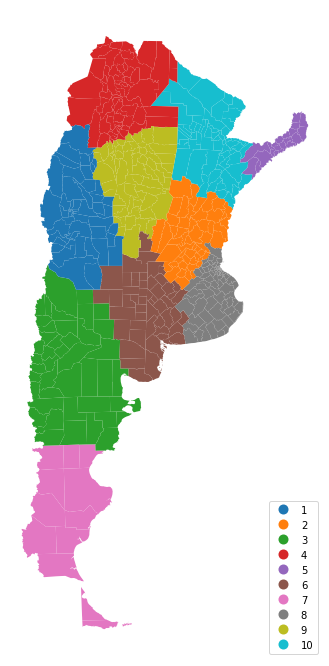

In [32]:
sim1.calcular_metodo('km',['coord'], centroides = False)
sim1.mapa('km')

In [33]:
resultados(sim1)

Metodo  Vers        hg    ind lq
9         km     1  0.555070  0.963636
9         km     2  0.472137  0.927273
0         km     3  0.560372  1.000000
0         km     4  0.560372  1.000000
9         km     5  0.960283  0.963636
3         km     6  1.000000  1.000000
4         km     6  1.000000  1.000000
5         km     6  1.000000  1.000000
6         km     6  1.000000  1.000000
7         km     6  1.000000  1.000000
8         km     6  1.000000  1.000000
9         km     6  1.000000  1.000000
11        km     6  1.000000  1.000000
12        km     6  1.000000  1.000000
13        km     6  1.000000  1.000000
14        km     6  1.000000  1.000000
15        km     6  1.000000  1.000000
16        km     6  1.000000  1.000000
17        km     6  1.000000  1.000000
18        km     6  1.000000  1.000000
10        km     7  0.962187  0.969697
12        km     8  0.966931  0.978022
9         km     9  0.838077  0.945455
9         km    10  0.922775  0.981818
8         km    11  0.903693  0.977778
4       aglo     1 -0.186157  1.000000
4       aglo     2  0.821534  1.000000
2       aglo     3  0.664884  1.000000
0       aglo     4  0.560372  1.000000
0       aglo     5  0.560372  1.000000
5       aglo     6  0.801573  1.000000
3       aglo     7  1.000000  1.000000
10      aglo     8  0.920084  0.984848
10      aglo     9  0.920084  0.984848
10      aglo    10  0.920084  0.984848
10      aglo    11  0.920084  0.984848
8   aglo_esp     1  0.994294  0.888889
9   aglo_esp     2  0.975209  0.854545
3   aglo_esp     3  0.822086  0.900000
18  aglo_esp     4  0.990020  0.731579
14  aglo_esp     5  0.953036  0.616667
7   aglo_esp     6  0.999916  0.916667
3   aglo_esp     7  1.000000  1.000000

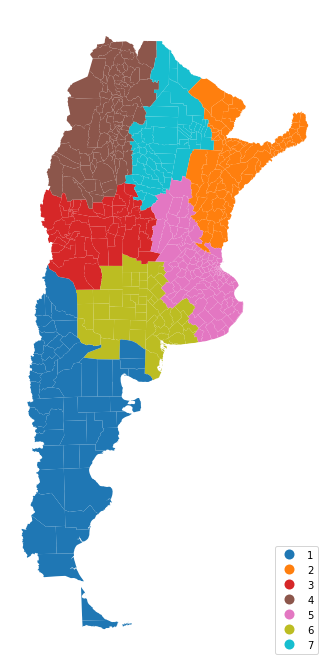

In [34]:
sim1.calcular_metodo('aglo_esp', [['var1','personas'],['I_Moran','prom_vecinos']], ae = True, n_encoders = 1)
sim1.mapa('aglo_esp')

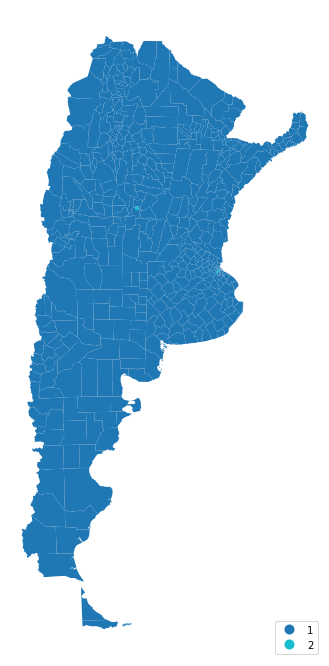

In [36]:
sim1.calcular_metodo('km', ['interac'], ae = True, n_encoders = 1)
sim1.calcular_metodo('km', ['interac'], ae = True, n_encoders = 1, centroides = False)
sim1.mapa('km')

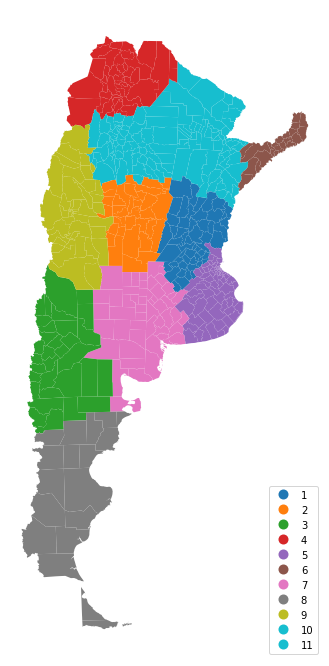

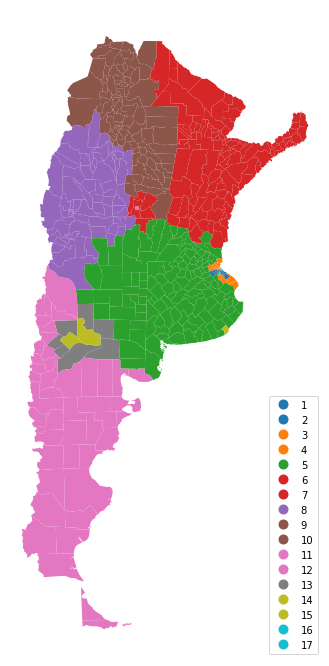

In [37]:
sim1.calcular_metodo('km', ['interac','interac_prom_vec'], ae = True, n_encoders = 1)
sim1.mapa('km')
sim1.calcular_metodo('aglo_esp', ['interac','interac_prom_vec'], ae = True, n_encoders = 1)
sim1.mapa('aglo_esp')

In [38]:
im = sim1.calc_Imoran(sim1.W, sim1.dic['porc'])
pv = sim1.calc_prom_vec(sim1.W, sim1.dic['porc'])
sim1.agregar_data('i_moran_porc', im, ajustar = False)
sim1.agregar_data('prom_vec_porc', pv, ajustar = False)

sim1.calcular_metodo('km', [['porc'],['i_moran_porc','prom_vec_porc']], ae = True, n_encoders = 1, centroides = False)
sim1.calcular_metodo('aglo_esp', [['porc'],['i_moran_porc','prom_vec_porc']], ae = True, n_encoders = 1, centroides = False)
resultados(sim1)

D:\Archivos\Codigos\COVID\regionalizacion.py:103: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  model.fit(data)
D:\Archivos\Codigos\COVID\lq.py:153: RuntimeWarning: invalid value encountered in double_scalars
  return (matriz.sum()/(p*(p-1)))
D:\Archivos\Codigos\COVID\regionalizacion.py:103: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  model.fit(data)
D:\Archivos\Codigos\COVID\lq.py:153: RuntimeWarning: invalid value encountered in double_scalars
  return (matriz.sum()/(p*(p-1)))
D:\Archivos\Codigos\COVID\regionalizacion.py:103: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  model.fit(data)
D:\Archivos\Codigos\COVID\lq.py:153: RuntimeWarning: invalid value encountered in double_scalars
  return (matriz.sum()/(p*(p-1)))
D:\Archivos\Codigos\COVID

Metodo  Vers        hg    ind lq
9         km     1  0.555070  0.963636
9         km     2  0.472137  0.927273
0         km     3  0.560372  1.000000
0         km     4  0.560372  1.000000
9         km     5  0.960283  0.963636
3         km     6  1.000000  1.000000
4         km     6  1.000000  1.000000
5         km     6  1.000000  1.000000
6         km     6  1.000000  1.000000
7         km     6  1.000000  1.000000
8         km     6  1.000000  1.000000
9         km     6  1.000000  1.000000
11        km     6  1.000000  1.000000
12        km     6  1.000000  1.000000
13        km     6  1.000000  1.000000
14        km     6  1.000000  1.000000
15        km     6  1.000000  1.000000
16        km     6  1.000000  1.000000
17        km     6  1.000000  1.000000
18        km     6  1.000000  1.000000
10        km     7  0.962187  0.969697
12        km     8  0.966931  0.978022
9         km     9  0.838077  0.945455
9         km    10  0.922775  0.981818
8         km    11  0.903693  0.977778
9         km    12  0.959387  0.981818
3         km    14  0.665100  1.000000
0         km    15  0.560372  1.000000
9         km    16  0.957708  0.981818
4       aglo     1 -0.186157  1.000000
4       aglo     2  0.821534  1.000000
2       aglo     3  0.664884  1.000000
0       aglo     4  0.560372  1.000000
0       aglo     5  0.560372  1.000000
5       aglo     6  0.801573  1.000000
3       aglo     7  1.000000  1.000000
10      aglo     8  0.920084  0.984848
10      aglo     9  0.920084  0.984848
10      aglo    10  0.920084  0.984848
10      aglo    11  0.920084  0.984848
8   aglo_esp     1  0.994294  0.888889
9   aglo_esp     2  0.975209  0.854545
3   aglo_esp     3  0.822086  0.900000
18  aglo_esp     4  0.990020  0.731579
14  aglo_esp     5  0.953036  0.616667
7   aglo_esp     6  0.999916  0.916667
3   aglo_esp     7  1.000000  1.000000
5   aglo_esp     8  0.641367  1.000000
15  aglo_esp     9  0.948833  0.661765
4   aglo_esp    10  0.769070  1.000000

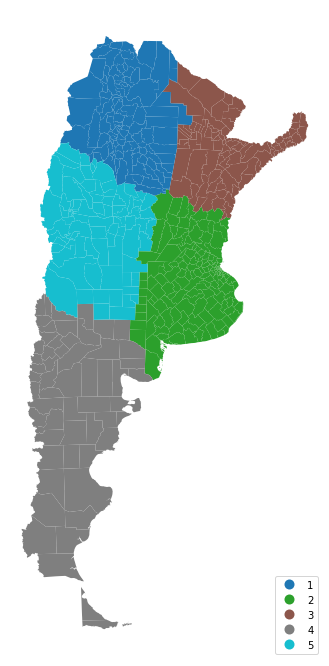

In [39]:
sim1.mapa('km',14)

In [40]:
sim1.autoencoder.summary()

Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None, 2)]          0           []                               
                                                                                                  
 dense_58 (Dense)               (None, 1)            2           ['input_27[0][0]']               
                                                                                                  
 dense_59 (Dense)               (None, 1)            3           ['input_28[0][0]']               
                                                                                           

## Segundo ejemplo

Voy a suponer que la distribución sigue igual, salvo por una provincia que se separa de toda la región a la que pertenece

In [41]:
regiones = cov.reg.copy()
regiones[cov.provincia == "Tucumán"] = 6
cov['reg'] = regiones
var = cov.reg.map({1:0.0001,2:0.001,3:0.1, 4:0.3, 5:0.7,6:0.7})* cov.personas
#transformo la variable en un GeoDataFrame para seguir trabajando y le agrego la variable personas que sería la variable poblacional
var = pd.concat([var,cov.personas], axis = 1)
var = var.rename(columns = {0:'var1'})
var = var.droplevel('mes')
var = gpd.GeoDataFrame(var, geometry = geo)
var.head()

var1  personas                                           geometry
link                                                                      
2001  61765.8    205886  POLYGON ((4200350.769 6147470.664, 4201101.267...
2002  47379.6    157932  POLYGON ((4198043.775 6148577.659, 4198111.775...
2003  56261.1    187537  POLYGON ((4198450.276 6145157.669, 4198456.277...
2004  65473.5    218245  POLYGON ((4201672.770 6142869.179, 4201695.770...
2005  53701.5    179005  POLYGON ((4196342.782 6145516.166, 4196373.783...

In [42]:
sim2 = reg.entorno(var, ['var1'],'personas', pipe)
sim2.procesar_datos()
sim2.metric.obtener_panel(periodos = 1, variables = 1)
param = {'n_clusters' : [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]} #se crean los distintos parametros para probar, en este caso solo de cantidad de grupos
metricas = {'hg': sim1.metric.Hg_relat, 'ind lq': sim1.metric.indice_lq} # se crean las metricas. En este caso las que provienen del LQ y es importante que salgan del entorno así buscan bien los datos

sim2.agregar_metodo('km', KMeans(), param, metricas)
sim2.agregar_metodo('aglo', AgglomerativeClustering(), param, metricas)

C:\Anaconda3\envs\covid2\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


convertir a panel los datos


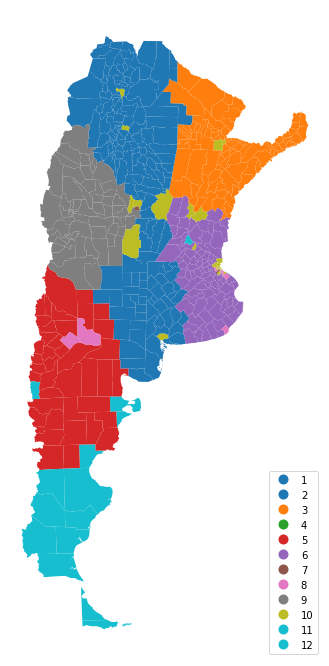

In [43]:
sim2.calcular_metodo('km', [['var1','personas']])
sim2.mapa('km')

In [44]:
sim2.calcular_metodo('km', [['var1','personas','I_Moran','prom_vecinos']])
sim2.calcular_metodo('aglo', [['var1','personas']])
sim2.calcular_metodo('aglo', [['var1','personas','I_Moran','prom_vecinos']])
sim2.calcular_metodo('km', [['var1','personas','I_Moran','prom_vecinos']], ae = True, n_encoders = 1)
sim2.calcular_metodo('aglo', [['var1','personas','I_Moran','prom_vecinos']], ae = True, n_encoders = 1)
resultados(sim2)

Metodo  Vers        hg    ind lq
10     km     1  0.400937  0.984848
0      km     2 -0.919331  1.000000
10     km     3  0.963290  0.969697
4    aglo     1 -0.169794  1.000000
4    aglo     2  0.267963  1.000000
3    aglo     3  0.615015  1.000000

In [45]:
sim2.met_desc

{'km': {1: {'columnas': [['var1', 'personas']], 'ae': False},
  2: {'columnas': [['var1', 'personas', 'I_Moran', 'prom_vecinos']],
   'ae': False},
  3: {'columnas': [['var1', 'personas', 'I_Moran', 'prom_vecinos']],
   'ae': True}},
 'aglo': {1: {'columnas': [['var1', 'personas']], 'ae': False},
  2: {'columnas': [['var1', 'personas', 'I_Moran', 'prom_vecinos']],
   'ae': False},
  3: {'columnas': [['var1', 'personas', 'I_Moran', 'prom_vecinos']],
   'ae': True}}}

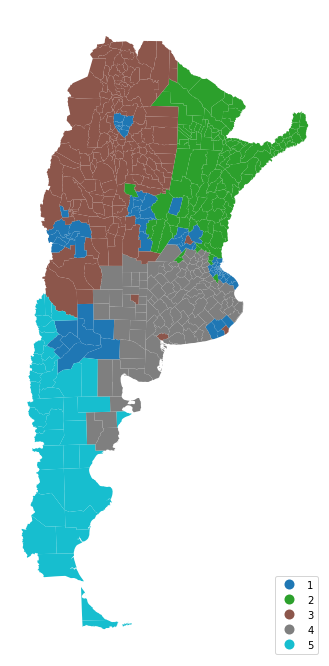

In [46]:
sim2.mapa('aglo', 3)

In [47]:
sim2.metric.regiones = cov.reg.values
sim2.metric.MI(var,sim2.metodos_rdos['km'][3].best_model_.iloc[0]['modelo'].labels_)

0.6402078444112689

In [48]:
sim2.met_desc

{'km': {1: {'columnas': [['var1', 'personas']], 'ae': False},
  2: {'columnas': [['var1', 'personas', 'I_Moran', 'prom_vecinos']],
   'ae': False},
  3: {'columnas': [['var1', 'personas', 'I_Moran', 'prom_vecinos']],
   'ae': True}},
 'aglo': {1: {'columnas': [['var1', 'personas']], 'ae': False},
  2: {'columnas': [['var1', 'personas', 'I_Moran', 'prom_vecinos']],
   'ae': False},
  3: {'columnas': [['var1', 'personas', 'I_Moran', 'prom_vecinos']],
   'ae': True}}}

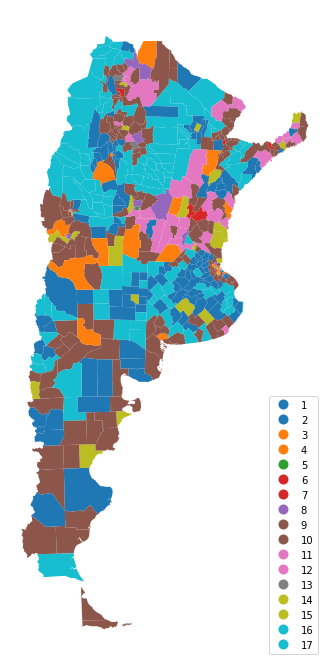

In [49]:
sim2.calcular_metodo('km', [['var1','personas'],['I_Moran','prom_vecinos']], ae = True, n_encoders = 2,centroides = False)
sim2.mapa('km')

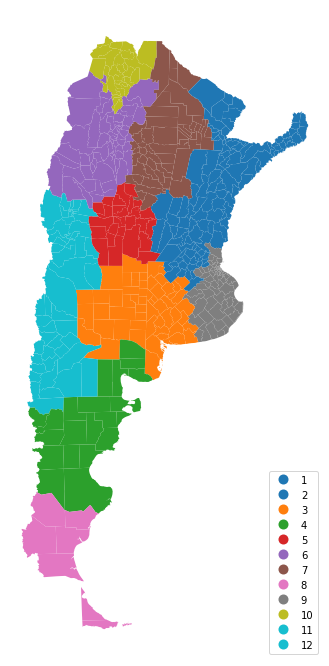

In [50]:
sim2.calcular_metodo('aglo', [['var1','personas'],['I_Moran','prom_vecinos']], ae = True, n_encoders = 1,centroides = True)
sim2.mapa('aglo')

In [51]:
sim2.agregar_data('porc',(sim2.df.var1/sim2.df.personas).values.reshape(-1,1), ajustar = False)

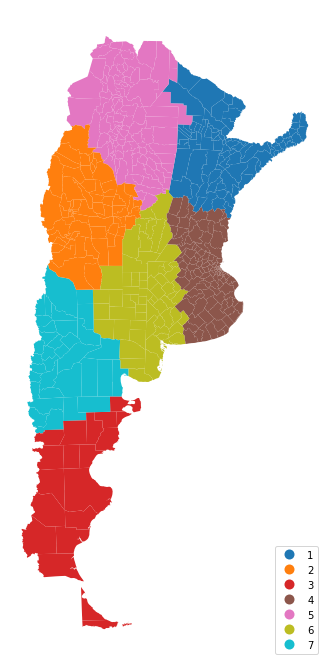

D:\Archivos\Codigos\COVID\regionalizacion.py:103: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  model.fit(data)
D:\Archivos\Codigos\COVID\regionalizacion.py:103: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  model.fit(data)
D:\Archivos\Codigos\COVID\regionalizacion.py:103: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  model.fit(data)
D:\Archivos\Codigos\COVID\regionalizacion.py:103: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  model.fit(data)
D:\Archivos\Codigos\COVID\regionalizacion.py:103: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  model.fit(data)
D:\Archivos\Codigos\COVID\re

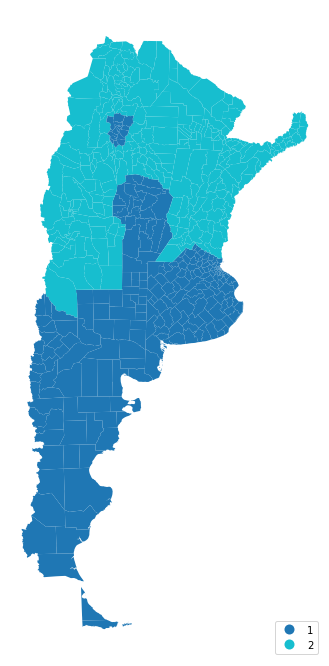

In [52]:
sim2.calcular_metodo('km', ['porc'], centroides = True)
sim2.mapa('km')
sim2.calcular_metodo('km', ['porc'], centroides = False)
sim2.mapa('km')

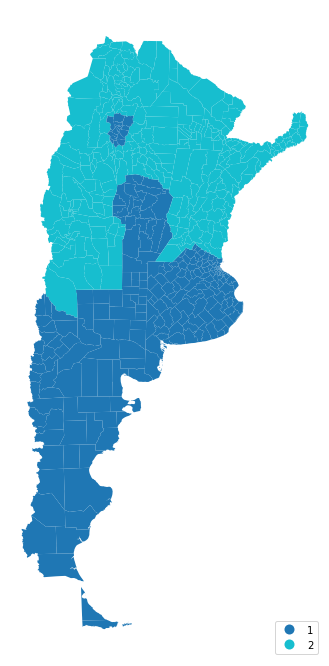

In [53]:
sim2.calcular_metodo('aglo', ['porc'], centroides = False)
sim2.mapa('aglo')

In [54]:
np.unique(sim2.retornar_dfs(separado = ['porc'])[0])

array([1.e-04, 1.e-04, 1.e-04, 1.e-03, 1.e-01, 1.e-01, 1.e-01, 3.e-01,
       3.e-01, 7.e-01, 7.e-01, 7.e-01])

D:\Archivos\Codigos\COVID\regionalizacion.py:103: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  model.fit(data)
D:\Archivos\Codigos\COVID\regionalizacion.py:103: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  model.fit(data)
D:\Archivos\Codigos\COVID\regionalizacion.py:103: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  model.fit(data)
D:\Archivos\Codigos\COVID\regionalizacion.py:103: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (18). Possibly due to duplicate points in X.
  model.fit(data)
D:\Archivos\Codigos\COVID\regionalizacion.py:103: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (19). Possibly due to duplicate points in X.
  model.fit(data)
D:\Archivos\Codigos\

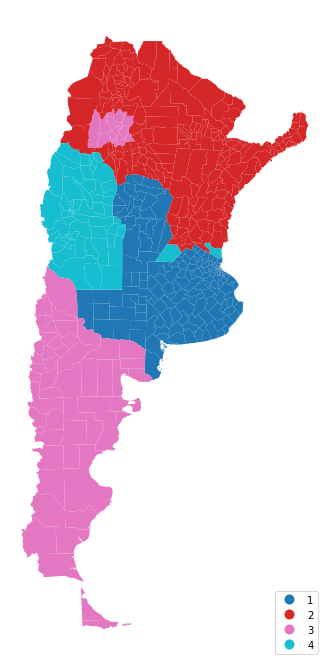

In [55]:
im = sim2.calc_Imoran(sim2.W,sim2.dic['porc'])
pv = sim2.calc_prom_vec(sim2.W,sim2.dic['porc'])
sim2.agregar_data('I_moran_porc', im, ajustar = False)
sim2.agregar_data('prom_vec_porc', im, ajustar = False)
sim2.calcular_metodo('km', ['porc', ['I_moran_porc', 'prom_vec_porc']], ae = True, n_encoders = 1,centroides = False)
sim2.mapa('km')

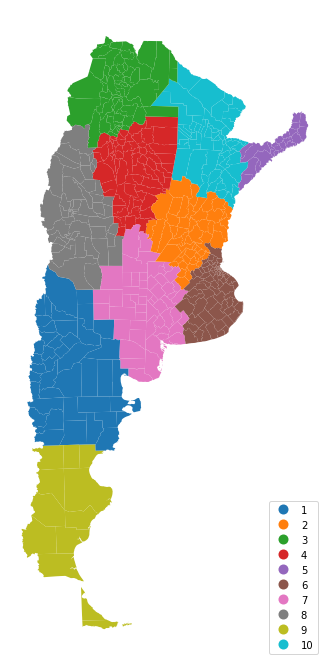

In [56]:
sim2.calcular_metodo('km', ['porc', ['I_moran_porc', 'prom_vec_porc']], ae = True, n_encoders = 1,centroides = True)
sim2.mapa('km')

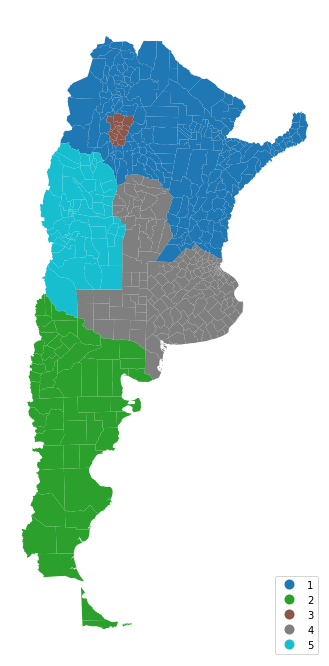

In [57]:
param_aglo = reg.copy(param)
param_aglo['connectivity'] = [sim2.W.sparse]
#param_aglo['linkage'] = 'complete'
sim2.agregar_metodo('aglo_esp', AgglomerativeClustering(), param_aglo, metricas)
sim2.calcular_metodo('aglo_esp', ['porc'], centroides = False)
sim2.mapa('aglo_esp')

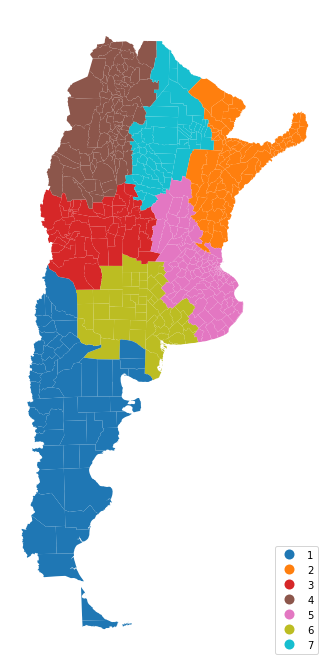

In [58]:
sim2.calcular_metodo('aglo_esp', ['porc', ['I_moran_porc', 'prom_vec_porc']], ae = True, n_encoders = 1,centroides = True)
sim2.mapa('aglo_esp')

<AxesSubplot:>

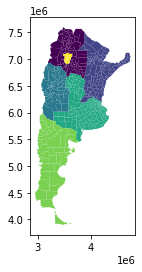

In [59]:
cov.plot('reg')

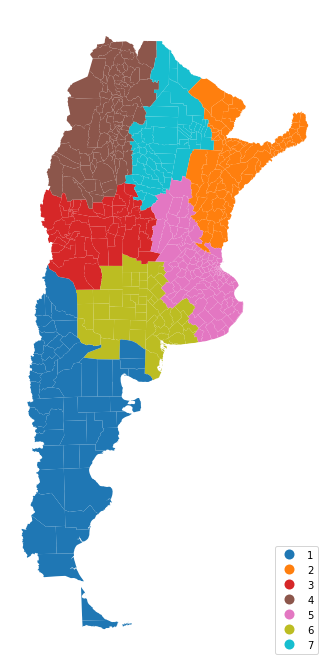

In [60]:
sim2.calcular_metodo('aglo_esp', ['porc', ['I_moran_porc', 'prom_vec_porc']], ae = True, n_encoders = 1,centroides = True, optimizer = "adam", loss = "kl_divergence")
sim2.mapa('aglo_esp')

In [61]:
sim2.agregar_data('W',sim2.W.sparse.todense(),ajustar = False)

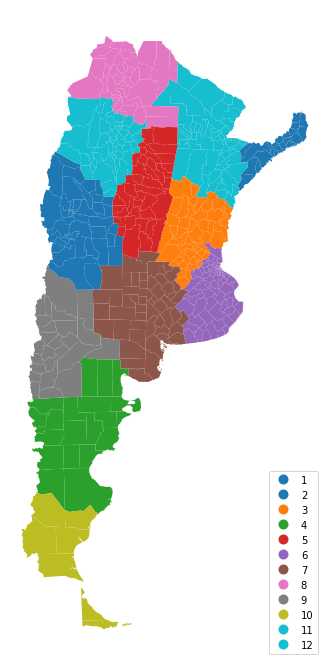

In [62]:
sim2.calcular_metodo('km', [['porc','W'], ['I_moran_porc', 'prom_vec_porc']], ae = True, n_encoders = 1,centroides = True, optimizer = "adam", loss = "kl_divergence")
sim2.mapa('km')

In [63]:
sim2.autoencoder.loss

'kl_divergence'

In [64]:
resultados(sim2)

Metodo  Vers        hg    ind lq
10        km     1  0.400937  0.984848
0         km     2 -0.919331  1.000000
10        km     3  0.963290  0.969697
15        km     4 -0.675006  0.933824
5         km     5  0.664933  1.000000
0         km     6  0.710636  1.000000
2         km     7  0.516302  1.000000
8         km     8  0.871077  0.977778
10        km     9  0.962040  0.969697
4       aglo     1 -0.169794  1.000000
4       aglo     2  0.267963  1.000000
3       aglo     3  0.615015  1.000000
10      aglo     4  0.920084  0.984848
0       aglo     5  0.710636  1.000000
3   aglo_esp     1  0.999999  1.000000
5   aglo_esp     2  0.641367  1.000000
5   aglo_esp     3  0.641367  1.000000

## Ejemplo 3

In [65]:
periodos = 20

x = cov.reg.map({1:lambda x: 0.0001+0.0001*x,2:lambda x :0.001 +0.001*x,3:lambda x: 0.1+0.001*x, 4:lambda x: 0.3-0.001*x, 5:lambda x: 0.7-0.005*x,6:lambda x: 0.7-0.005*x})

p = np.arange(0,periodos)

val = []
for i in x:
    y = i(p)
    val.append(y)
val = np.array(val)


In [66]:
var = val*cov[['personas']].values
var[0] == val[0]*cov[['personas']].values[0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [67]:
var = pd.DataFrame(var, columns = pd.MultiIndex.from_tuples(tuple(zip(['var1']*20,p))), index = cov.index) 
var_ = var.stack()
var_['personas'] = np.array([cov.personas.values,]*20).T.reshape(525*20,1)
var = var_.droplevel('mes')
var = gpd.GeoDataFrame(var, geometry = np.array([cov.geometry.values,]*20).T.reshape(525*20,))
var.head()

var1  personas                                           geometry
link                                                                          
2001 0  61765.800    205886  POLYGON ((4200350.769 6147470.664, 4201101.267...
     1  61559.914    205886  POLYGON ((4200350.769 6147470.664, 4201101.267...
     2  61354.028    205886  POLYGON ((4200350.769 6147470.664, 4201101.267...
     3  61148.142    205886  POLYGON ((4200350.769 6147470.664, 4201101.267...
     4  60942.256    205886  POLYGON ((4200350.769 6147470.664, 4201101.267...

In [68]:
sim3 = reg.entorno(var,['var1'],'personas', pipe)

C:\Anaconda3\envs\covid2\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)
C:\Anaconda3\envs\covid2\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


In [69]:
sim3.procesar_datos()
param = {'n_clusters' : [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]} #se crean los distintos parametros para probar, en este caso solo de cantidad de grupos
metricas = {'hg': sim3.metric.Hg_relat, 'ind lq': sim3.metric.indice_lq} # se crean las metricas. En este caso las que provienen del LQ y es importante que salgan del entorno así buscan bien los datos
param_aglo = reg.copy(param)
param_aglo['connectivity'] = [sim3.W.sparse]

sim3.agregar_metodo('km', KMeans(), param, metricas)
sim3.agregar_metodo('aglo', AgglomerativeClustering(), param, metricas)
sim3.agregar_metodo('aglo_esp', AgglomerativeClustering(), param_aglo, metricas)

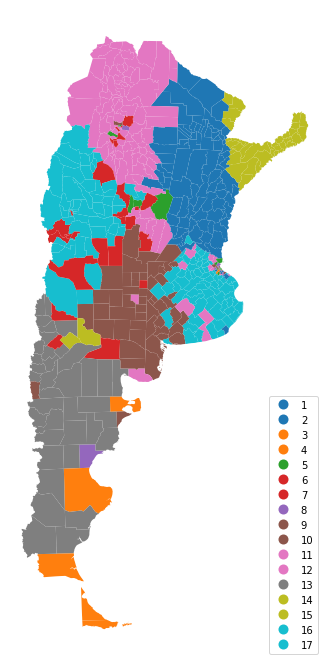

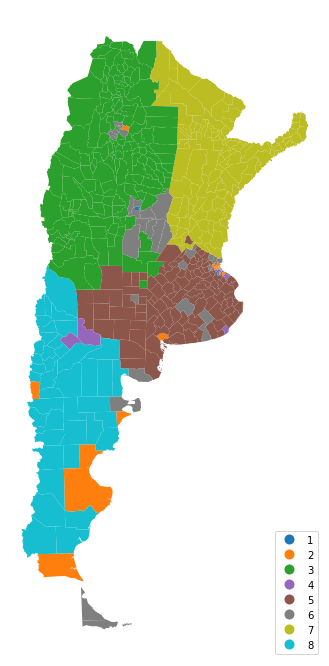

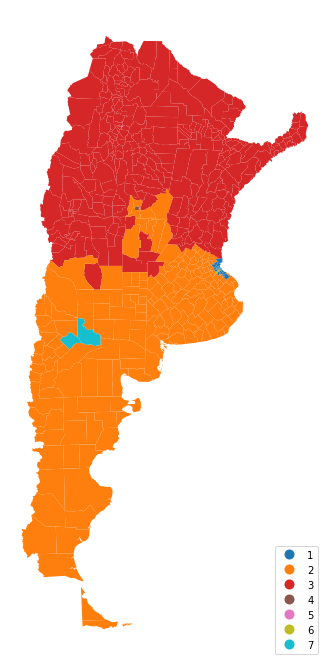

(None, None, None)

In [70]:
np.random.seed(3254)
sim3.calcular_metodo('km', ['var1','personas'])
sim3.calcular_metodo('aglo', ['var1','personas'])
sim3.calcular_metodo('aglo_esp', ['var1','personas'])
sim3.mapa('km'),sim3.mapa('aglo'),sim3.mapa('aglo_esp')

In [71]:
resultados(sim3)

Metodo  Vers        hg    ind lq
15        km     1 -0.510340  0.955882
6       aglo     1 -2.110130  1.000000
5   aglo_esp     1  0.966544  0.857143

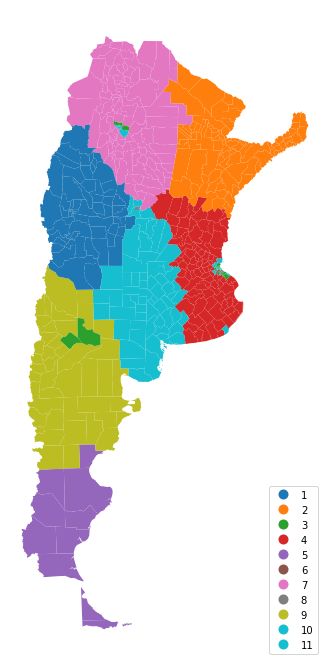

In [72]:
sim3.calcular_metodo('km', [['var1','personas'],['I_Moran','prom_vecinos']], ae =True, n_encoders = 1)
sim3.mapa('km')

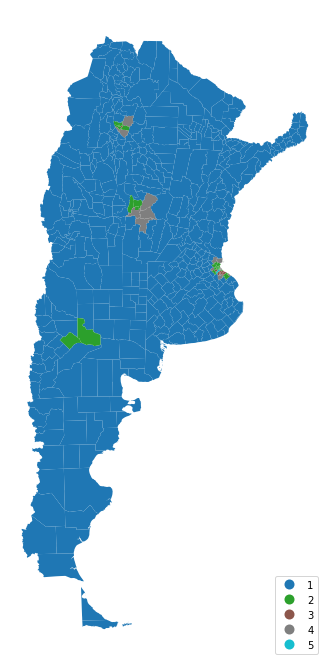

In [73]:
sim3.calcular_metodo('km', [['var1','personas'],['I_Moran','prom_vecinos']], ae =True, n_encoders = 1, centroides = False)
sim3.mapa('km')

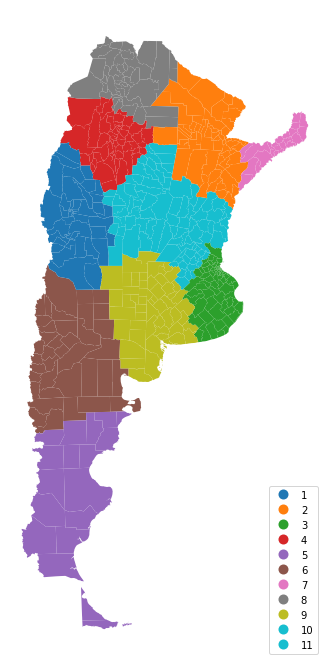

In [74]:
sim3.agregar_data('W', sim3.W.sparse.todense(), ajustar = False)
sim3.calcular_metodo('km', [['var1','personas','W'],['I_Moran','prom_vecinos']], ae =True, n_encoders = 1)
sim3.mapa('km')

In [75]:
resultados(sim3)

Metodo  Vers        hg    ind lq
15        km     1 -0.510340  0.955882
9         km     2 -0.015419  0.981818
3         km     3 -0.370838  1.000000
9         km     4  0.959670  0.981818
6       aglo     1 -2.110130  1.000000
5   aglo_esp     1  0.966544  0.857143

In [76]:
sim3.interacciones()

In [77]:
sim3.dic.keys()

dict_keys(['var1', 'personas', 'coord', 'I_Moran', 'prom_vecinos', 'W', 'interac', 'interac_Imoran', 'interac_prom_vec'])

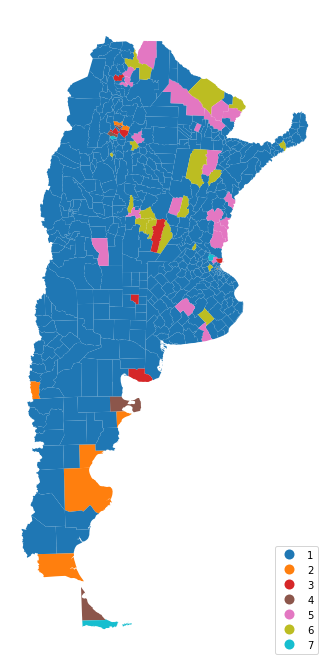

In [78]:
sim3.calcular_metodo('km', [['interac','W']], ae = True, centroides = False)
sim3.mapa('km')

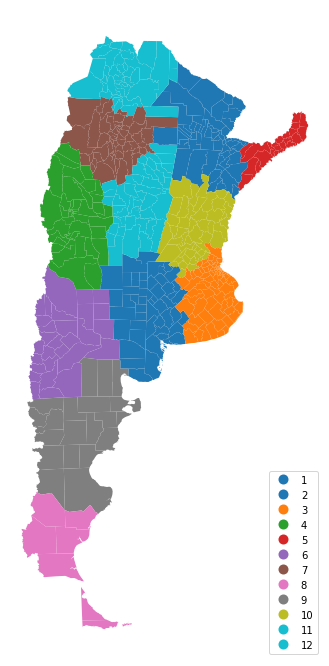

In [79]:
sim3.calcular_metodo('km', [['interac','W']], ae = True, centroides = True)
sim3.mapa('km')

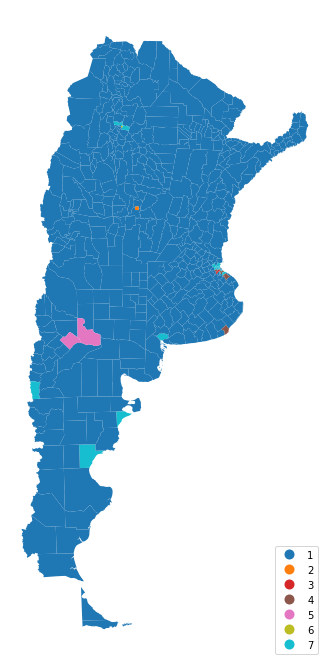

In [80]:
sim3.calcular_metodo('km', [['interac'],['W']], ae = True,n_encoders = 2, centroides = False)
sim3.mapa('km')

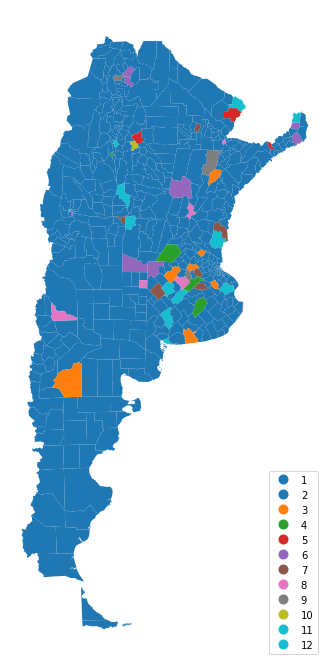

In [81]:
sim3.calcular_metodo('km', [['interac'],['W','interac_prom_vec']], ae = True,n_encoders = 2, centroides = False)
sim3.mapa('km')

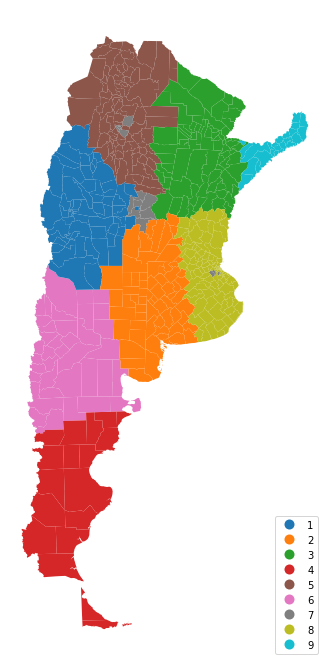

In [82]:
sim3.calcular_metodo('km', [['interac'],['W','interac_prom_vec']], ae = True,n_encoders = 2, centroides = True)
sim3.mapa('km')

In [83]:
sim3.agregar_data('porc',sim3.df[['var1']].values/sim3.df[['personas']].values, ajustar = False)

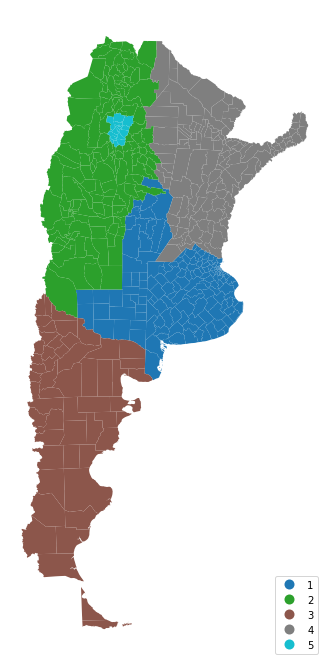

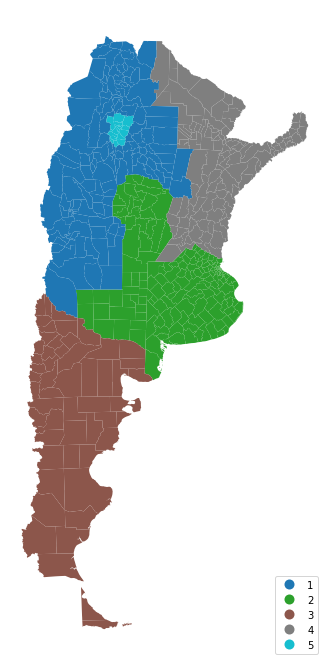

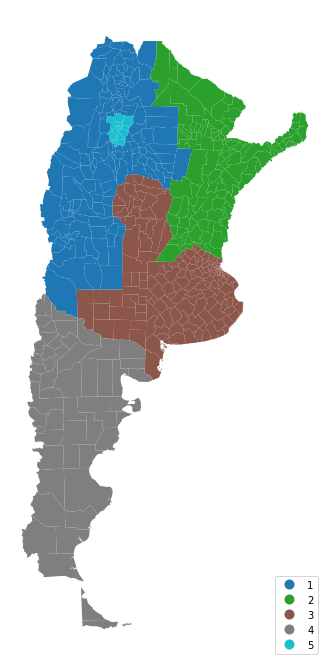

(None, None, None)

In [84]:
sim3.calcular_metodo('km', ['porc'])
sim3.calcular_metodo('aglo', ['porc'])
sim3.calcular_metodo('aglo_esp', ['porc'])
sim3.mapa('km'), sim3.mapa('aglo'),sim3.mapa('aglo_esp')

In [85]:
resultados(sim3)

Metodo  Vers        hg    ind lq
15        km     1 -0.510340  0.955882
9         km     2 -0.015419  0.981818
3         km     3 -0.370838  1.000000
9         km     4  0.959670  0.981818
5         km     5 -0.138016  1.000000
10        km     6  0.965786  0.969697
5         km     7  0.786311  0.857143
10        km     8  0.805402  0.984848
7         km     9  0.704876  1.000000
3         km    10  0.988593  1.000000
6       aglo     1 -2.110130  1.000000
3       aglo     2  0.994608  1.000000
5   aglo_esp     1  0.966544  0.857143
3   aglo_esp     2  0.994578  1.000000

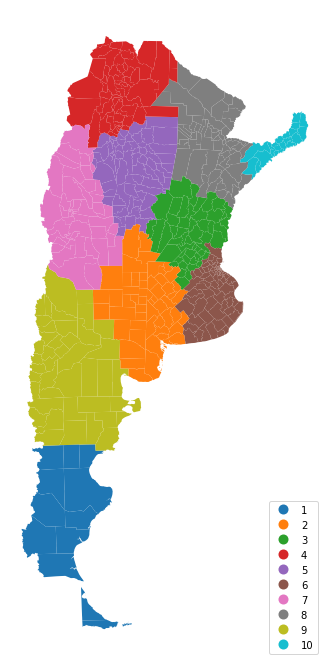

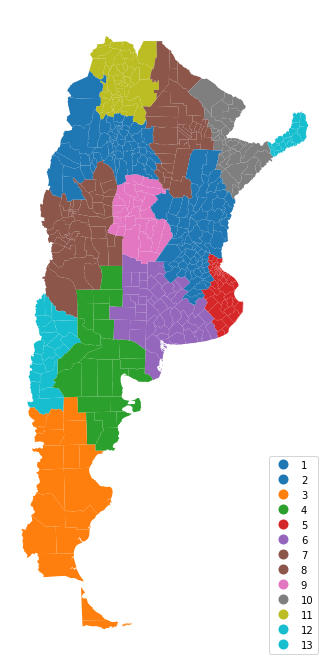

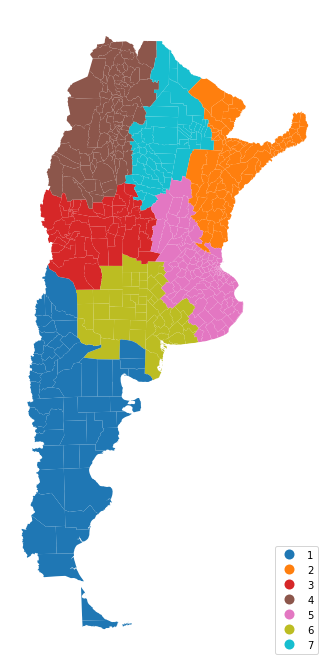

(None, None, None)

In [86]:
sim3.calcular_metodo('km', ['porc'], ae = True, n_encoders = 1)
sim3.calcular_metodo('aglo', ['porc'], ae = True, n_encoders = 1)
sim3.calcular_metodo('aglo_esp', ['porc'], ae = True, n_encoders = 1)
sim3.mapa('km'), sim3.mapa('aglo'),sim3.mapa('aglo_esp')

In [87]:
resultados(sim3)

Metodo  Vers        hg    ind lq
15        km     1 -0.510340  0.955882
9         km     2 -0.015419  0.981818
3         km     3 -0.370838  1.000000
9         km     4  0.959670  0.981818
5         km     5 -0.138016  1.000000
10        km     6  0.965786  0.969697
5         km     7  0.786311  0.857143
10        km     8  0.805402  0.984848
7         km     9  0.704876  1.000000
3         km    10  0.988593  1.000000
8         km    11  0.872881  0.977778
6       aglo     1 -2.110130  1.000000
3       aglo     2  0.994608  1.000000
11      aglo     3  0.971067  0.910256
5   aglo_esp     1  0.966544  0.857143
3   aglo_esp     2  0.994578  1.000000
5   aglo_esp     3  0.641367  1.000000

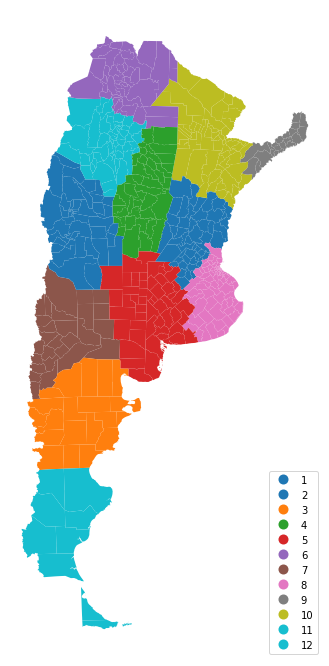

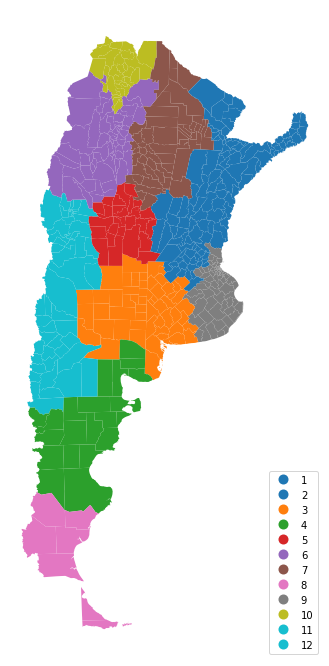

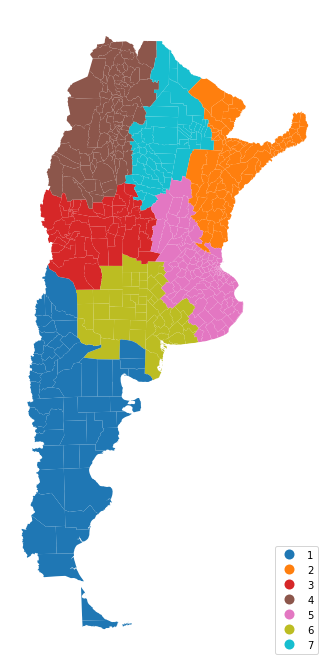

(None, None, None)

In [88]:
sim3.calcular_metodo('km', ['porc','W'], ae = True, n_encoders = 1)
sim3.calcular_metodo('aglo', ['porc','W'], ae = True, n_encoders = 1)
sim3.calcular_metodo('aglo_esp', ['porc','W'], ae = True, n_encoders = 1)
sim3.mapa('km'), sim3.mapa('aglo'),sim3.mapa('aglo_esp')

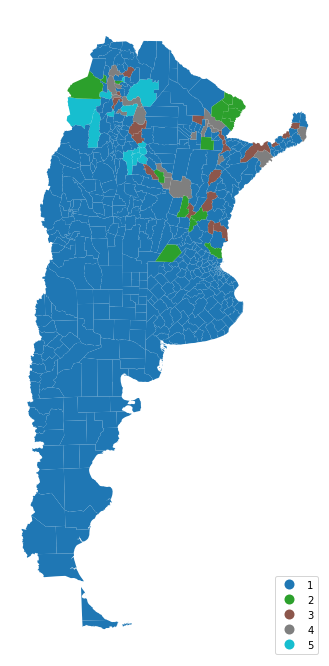

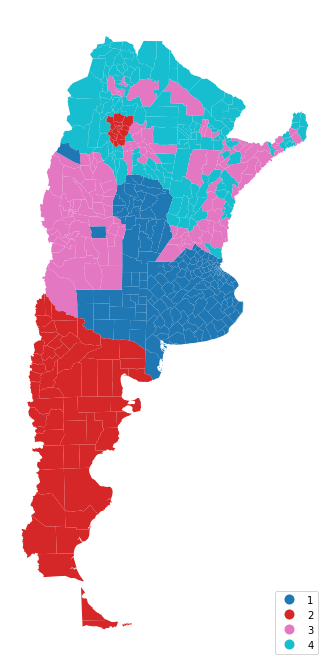

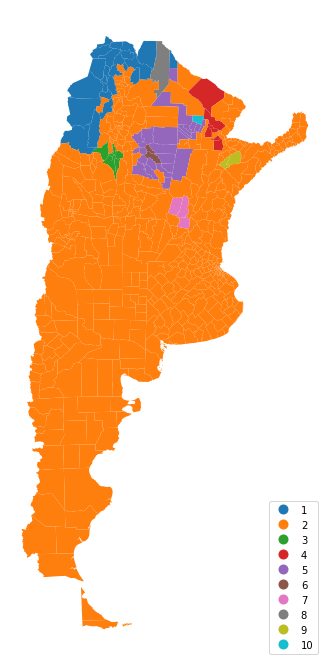

(None, None, None)

In [90]:
sim3.calcular_metodo('km', ['porc','W'], ae = True, n_encoders = 2, centroides = False)
sim3.calcular_metodo('aglo', ['porc','W'], ae = True, n_encoders = 2, centroides = False)
sim3.calcular_metodo('aglo_esp', ['porc','W'], ae = True, n_encoders = 2, centroides = False)
sim3.mapa('km'), sim3.mapa('aglo'),sim3.mapa('aglo_esp')

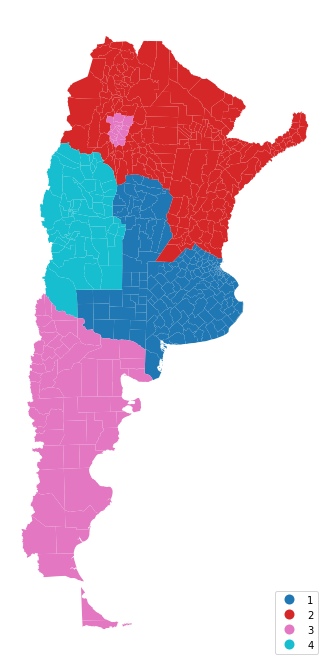

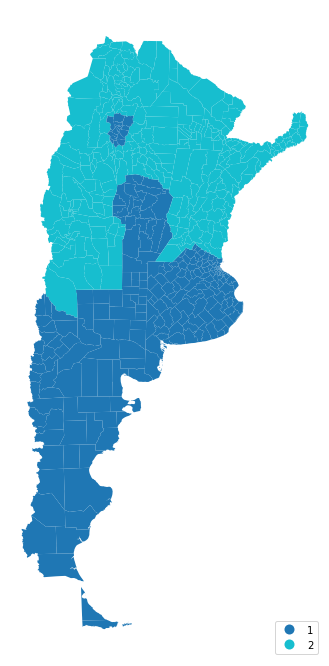

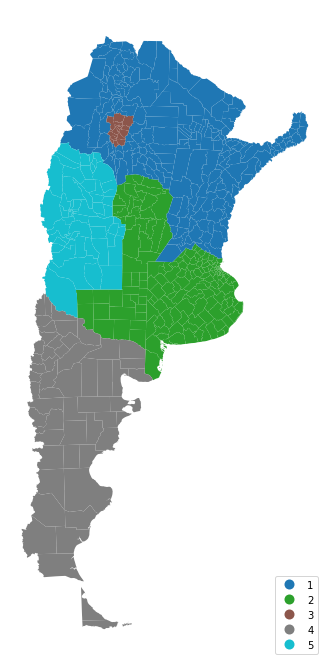

(None, None, None)

In [91]:
sim3.calcular_metodo('km', ['porc','W'], ae = True, n_encoders = 4, centroides = False)
sim3.calcular_metodo('aglo', ['porc','W'], ae = True, n_encoders = 4, centroides = False)
sim3.calcular_metodo('aglo_esp', ['porc','W'], ae = True, n_encoders = 4, centroides = False)
sim3.mapa('km'), sim3.mapa('aglo'),sim3.mapa('aglo_esp')

In [92]:
sim3.autoencoder.summary()

Model: "model_96"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_84 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 input_85 (InputLayer)          [(None, 525)]        0           []                               
                                                                                                  
 dense_179 (Dense)              (None, 4)            84          ['input_84[0][0]']               
                                                                                                  
 dense_180 (Dense)              (None, 4)            2104        ['input_85[0][0]']               
                                                                                           

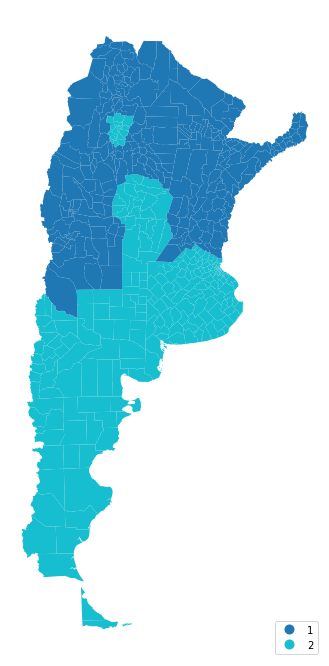

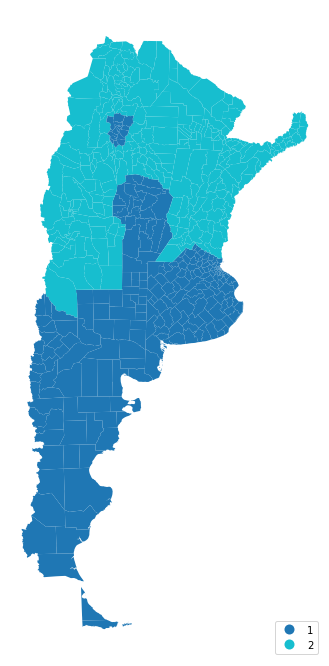

(None, None)

In [93]:
sim3.calcular_metodo('km', ['porc','W'], ae = True, n_encoders = 4, centroides = False, optimizer = 'sgd', loss = 'poisson')
sim3.calcular_metodo('aglo', ['porc','W'], ae = True, n_encoders = 4, centroides = False, optimizer = 'sgd', loss = 'poisson')
sim3.mapa('km'),sim3.mapa('aglo')

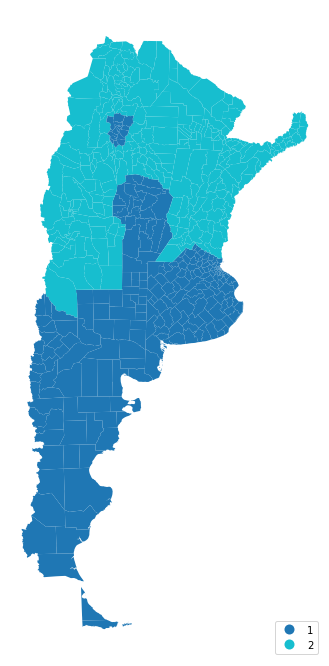

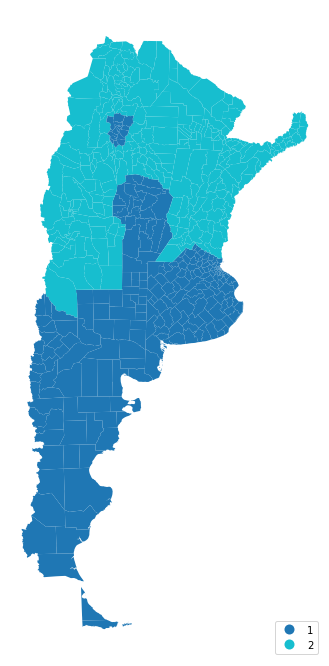

(None, None)

In [94]:
sim3.calcular_metodo('km', ['porc','W'], ae = True, n_encoders = 4, centroides = False, optimizer = 'sgd', loss = 'kl_divergence')
sim3.calcular_metodo('aglo', ['porc','W'], ae = True, n_encoders = 4, centroides = False, optimizer = 'sgd', loss = 'kl_divergence')
sim3.mapa('km'),sim3.mapa('aglo')

D:\Archivos\Codigos\COVID\regionalizacion.py:103: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  model.fit(data)
D:\Archivos\Codigos\COVID\regionalizacion.py:103: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  model.fit(data)
D:\Archivos\Codigos\COVID\regionalizacion.py:103: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  model.fit(data)
D:\Archivos\Codigos\COVID\regionalizacion.py:103: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  model.fit(data)
D:\Archivos\Codigos\COVID\regionalizacion.py:103: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  model.fit(data)
D:\Archivos\Codigos\COVID\reg

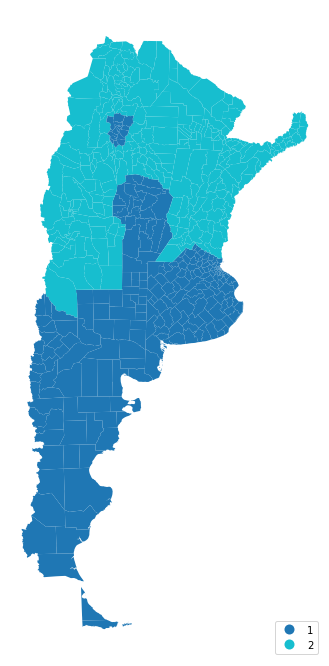

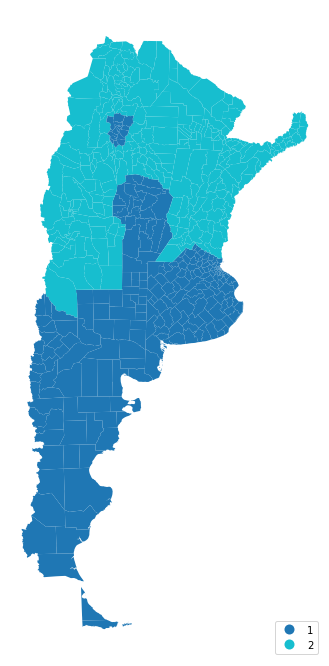

(None, None)

In [95]:
sim3.calcular_metodo('km', ['porc','W'], ae = True, n_encoders = 4, centroides = False, optimizer = 'adam', loss = 'kl_divergence')
sim3.calcular_metodo('aglo', ['porc','W'], ae = True, n_encoders = 4, centroides = False, optimizer = 'adam', loss = 'kl_divergence')
sim3.mapa('km'),sim3.mapa('aglo')

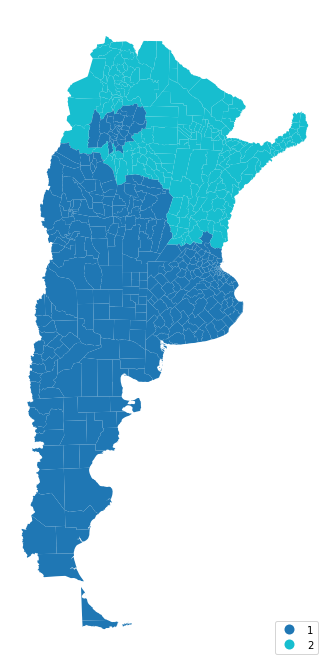

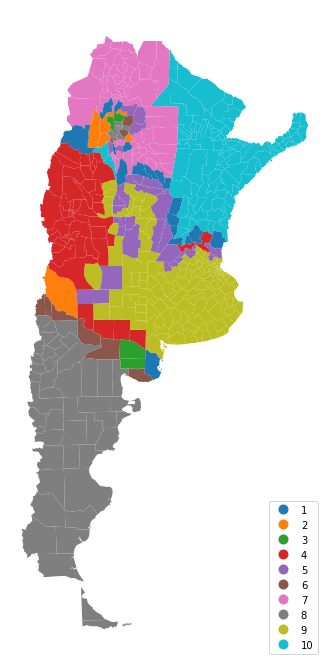

(None, None)

In [96]:
im = sim3.calc_Imoran(sim3.W, sim3.dic['porc'])
pv = sim3.calc_prom_vec(sim3.W, sim3.dic['porc'])
sim3.agregar_data('porc_Imoran', im)
sim3.agregar_data('porc_prom_vec', pv)

sim3.calcular_metodo('km', [['porc','W'],['porc_Imoran']], ae = True, n_encoders = 4, centroides = False, optimizer = 'sgd', loss = 'kl_divergence')
sim3.calcular_metodo('aglo', [['porc','W'],['porc_Imoran']], ae = True, n_encoders = 4, centroides = False, optimizer = 'sgd', loss = 'kl_divergence')
sim3.mapa('km'),sim3.mapa('aglo')

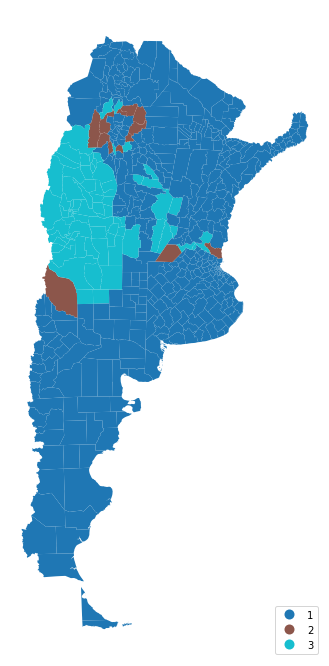

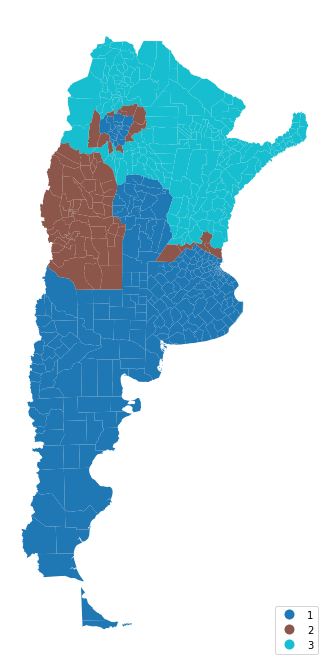

(None, None)

In [97]:
sim3.calcular_metodo('km', [['porc'],['W','porc_Imoran']], ae = True, n_encoders = 4, centroides = False, optimizer = 'sgd', loss = 'kl_divergence')
sim3.calcular_metodo('aglo', [['porc'],['W','porc_Imoran']], ae = True, n_encoders = 4, centroides = False, optimizer = 'sgd', loss = 'kl_divergence')
sim3.mapa('km'),sim3.mapa('aglo')

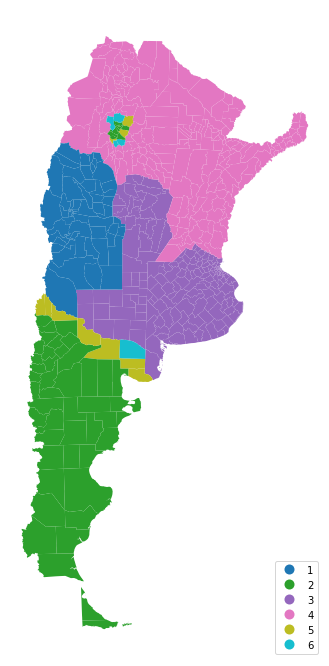

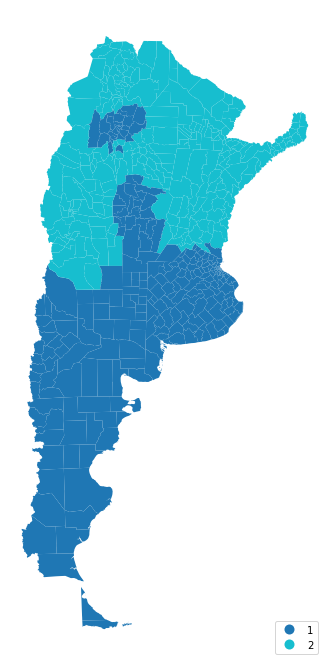

(None, None)

In [98]:
sim3.calcular_metodo('km', [['porc'],['W','porc_Imoran', 'porc_prom_vec']], ae = True, n_encoders = 4, centroides = False, optimizer = 'sgd', loss = 'kl_divergence')
sim3.calcular_metodo('aglo', [['porc'],['W','porc_Imoran', 'porc_prom_vec']], ae = True, n_encoders = 4, centroides = False, optimizer = 'sgd', loss = 'kl_divergence')
sim3.mapa('km'),sim3.mapa('aglo')

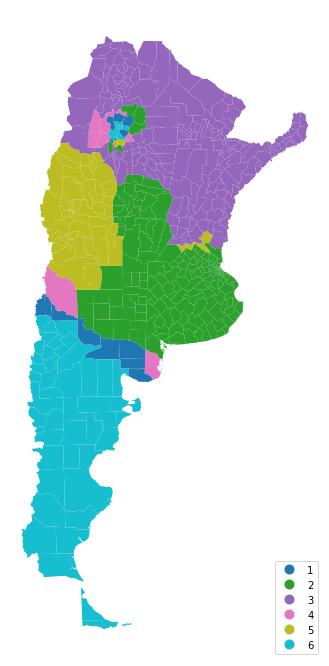

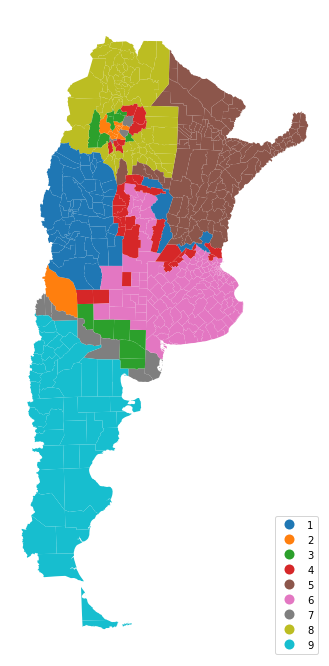

(None, None)

In [99]:
sim3.calcular_metodo('km', [['porc'],['W','porc_Imoran', 'porc_prom_vec']], ae = True, n_encoders = 4, centroides = True, optimizer = 'sgd', loss = 'kl_divergence')
sim3.calcular_metodo('aglo', [['porc'],['W','porc_Imoran', 'porc_prom_vec']], ae = True, n_encoders = 4, centroides = True, optimizer = 'sgd', loss = 'kl_divergence')
sim3.mapa('km'),sim3.mapa('aglo')

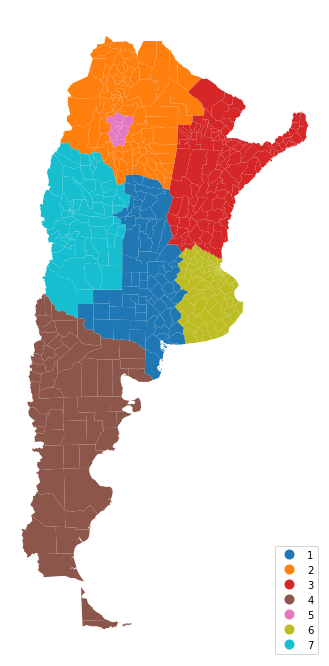

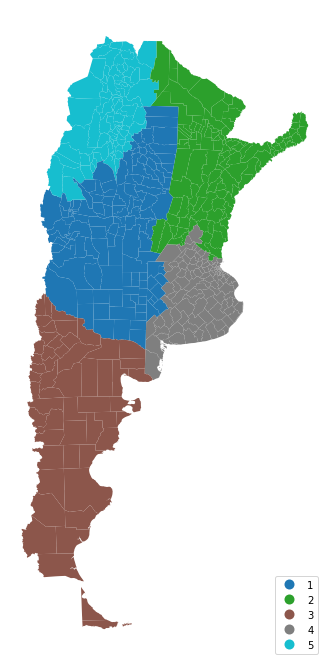

(None, None)

In [100]:
sim3.calcular_metodo('km', [['porc'],['W','porc_Imoran', 'porc_prom_vec']], ae = True, n_encoders = 4, centroides = True, optimizer = 'sgd', loss = 'cosine_similarity')
sim3.calcular_metodo('aglo', [['porc'],['W','porc_Imoran', 'porc_prom_vec']], ae = True, n_encoders = 4, centroides = True, optimizer = 'sgd', loss = 'cosine_similarity')
sim3.mapa('km'),sim3.mapa('aglo')

In [101]:
resultados(sim3)

Metodo  Vers        hg    ind lq
15        km     1 -0.510340  0.955882
9         km     2 -0.015419  0.981818
3         km     3 -0.370838  1.000000
9         km     4  0.959670  0.981818
5         km     5 -0.138016  1.000000
10        km     6  0.965786  0.969697
5         km     7  0.786311  0.857143
10        km     8  0.805402  0.984848
7         km     9  0.704876  1.000000
3         km    10  0.988593  1.000000
8         km    11  0.872881  0.977778
10        km    12  0.962268  0.969697
3         km    14  0.803515  0.600000
2         km    15  0.464639  1.000000
0         km    16  0.710636  1.000000
0         km    17  0.710636  1.000000
0         km    18  0.710636  1.000000
0         km    19  0.740451  1.000000
1         km    20  0.577024  1.000000
4         km    21  0.501524  1.000000
4         km    22  0.504834  1.000000
5         km    23  0.989622  0.952381
6       aglo     1 -2.110130  1.000000
3       aglo     2  0.994608  1.000000
11      aglo     3  0.971067  0.910256
10      aglo     4  0.920084  0.984848
1       aglo     5  0.779261  0.666667
2       aglo     6  0.450432  1.000000
0       aglo     7  0.710636  1.000000
0       aglo     8  0.710636  1.000000
0       aglo     9  0.710636  1.000000
0       aglo    10  0.710636  1.000000
8       aglo    11  0.675744  0.977778
1       aglo    12  0.813686  1.000000
0       aglo    13  0.699072  1.000000
7       aglo    14  0.900387  1.000000
3       aglo    15  0.651753  1.000000
5   aglo_esp     1  0.966544  0.857143
3   aglo_esp     2  0.994578  1.000000
5   aglo_esp     3  0.641367  1.000000
5   aglo_esp     4  0.641367  1.000000
3   aglo_esp     5  0.999451  1.000000
8   aglo_esp     6  0.892084  0.266667
3   aglo_esp     7  0.999999  1.000000

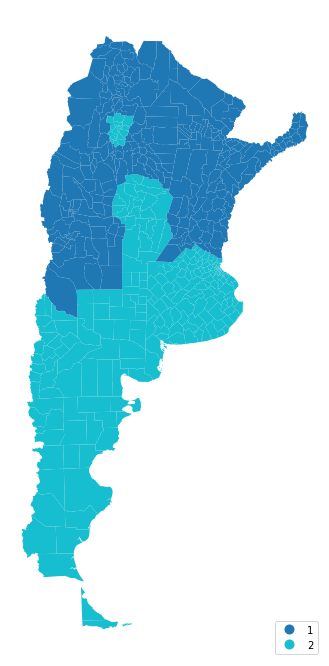

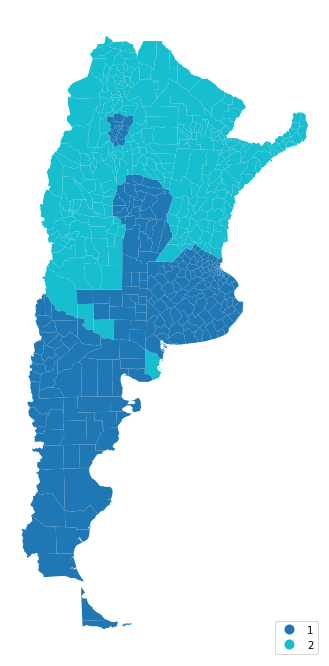

(None, None)

In [102]:
sim3.calcular_metodo('km', [['porc'],['W','porc_Imoran', 'porc_prom_vec']], ae = True, n_encoders = 4, centroides = False, optimizer = 'sgd', loss = 'cosine_similarity')
sim3.calcular_metodo('aglo', [['porc'],['W','porc_Imoran', 'porc_prom_vec']], ae = True, n_encoders = 4, centroides = False, optimizer = 'sgd', loss = 'cosine_similarity')
sim3.mapa('km'),sim3.mapa('aglo')

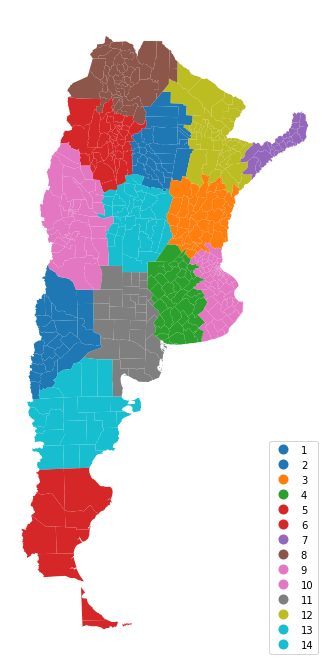

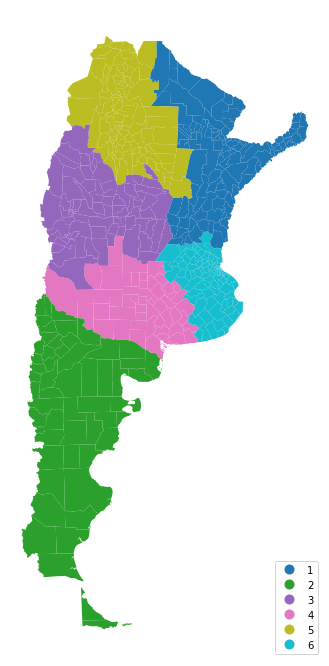

(None, None)

In [103]:
sim3.calcular_metodo('km', [['porc','W'],['porc_Imoran', 'porc_prom_vec']], ae = True, n_encoders = 4, centroides = True, optimizer = 'sgd', loss = 'cosine_similarity')
sim3.calcular_metodo('aglo', [['porc','W'],['porc_Imoran', 'porc_prom_vec']], ae = True, n_encoders = 4, centroides = True, optimizer = 'sgd', loss = 'cosine_similarity')
sim3.mapa('km'),sim3.mapa('aglo')

In [104]:
sim3.agregar_data('interac_porc',sim3.poly.fit_transform(sim3.dic['porc']))

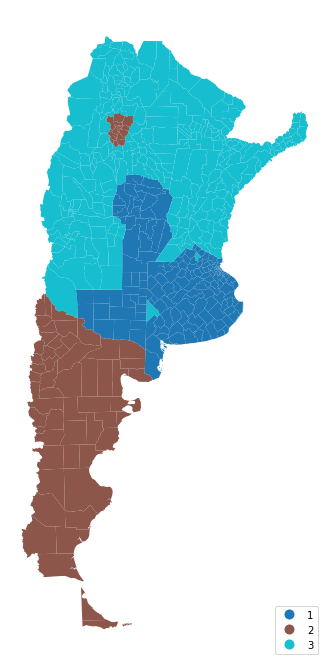

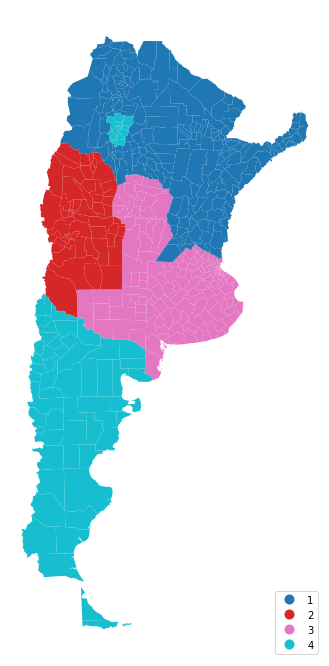

(None, None)

In [105]:
sim3.calcular_metodo('km', [['interac_porc'],['W']], ae = True, n_encoders = 4, centroides = False, optimizer = 'sgd', loss = 'cosine_similarity')
sim3.calcular_metodo('aglo', [['interac_porc'],['W']], ae = True, n_encoders = 4, centroides = False, optimizer = 'sgd', loss = 'cosine_similarity')
sim3.mapa('km'),sim3.mapa('aglo')

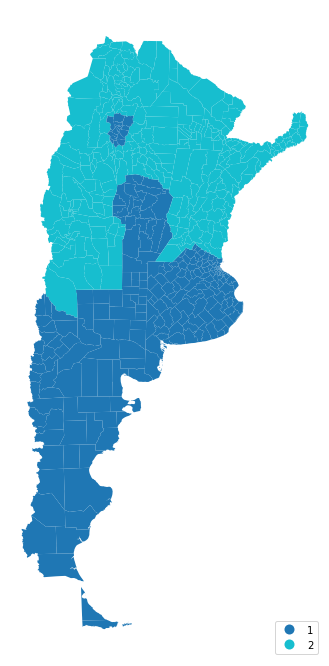

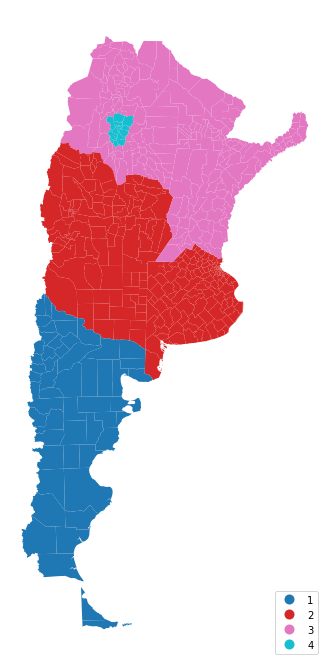

(None, None)

In [110]:
sim3.calcular_metodo('km', [['interac_porc'],['W','coord']], ae = True, n_encoders = 4, centroides = False, optimizer = 'sgd', loss = 'cosine_similarity')
sim3.calcular_metodo('aglo', [['interac_porc'],['W','coord']], ae = True, n_encoders = 4, centroides = False, optimizer = 'sgd', loss = 'cosine_similarity')
sim3.mapa('km'),sim3.mapa('aglo')

In [107]:
resultados(sim3)

Metodo  Vers        hg    ind lq
15        km     1 -0.510340  0.955882
9         km     2 -0.015419  0.981818
3         km     3 -0.370838  1.000000
9         km     4  0.959670  0.981818
5         km     5 -0.138016  1.000000
10        km     6  0.965786  0.969697
5         km     7  0.786311  0.857143
10        km     8  0.805402  0.984848
7         km     9  0.704876  1.000000
3         km    10  0.988593  1.000000
8         km    11  0.872881  0.977778
10        km    12  0.962268  0.969697
3         km    14  0.803515  0.600000
2         km    15  0.464639  1.000000
0         km    16  0.710636  1.000000
0         km    17  0.710636  1.000000
0         km    18  0.710636  1.000000
0         km    19  0.740451  1.000000
1         km    20  0.577024  1.000000
4         km    21  0.501524  1.000000
4         km    22  0.504834  1.000000
5         km    23  0.989622  0.952381
0         km    24  0.710636  1.000000
12        km    25  0.974338  0.978022
1         km    26  0.277619  1.000000
1         km    27  0.710679  1.000000
6       aglo     1 -2.110130  1.000000
3       aglo     2  0.994608  1.000000
11      aglo     3  0.971067  0.910256
10      aglo     4  0.920084  0.984848
1       aglo     5  0.779261  0.666667
2       aglo     6  0.450432  1.000000
0       aglo     7  0.710636  1.000000
0       aglo     8  0.710636  1.000000
0       aglo     9  0.710636  1.000000
0       aglo    10  0.710636  1.000000
8       aglo    11  0.675744  0.977778
1       aglo    12  0.813686  1.000000
0       aglo    13  0.699072  1.000000
7       aglo    14  0.900387  1.000000
3       aglo    15  0.651753  1.000000
0       aglo    16  0.707196  1.000000
4       aglo    17  0.916004  1.000000
2       aglo    18  0.464639  1.000000
3       aglo    19  0.455483  1.000000
5   aglo_esp     1  0.966544  0.857143
3   aglo_esp     2  0.994578  1.000000
5   aglo_esp     3  0.641367  1.000000
5   aglo_esp     4  0.641367  1.000000
3   aglo_esp     5  0.999451  1.000000
8   aglo_esp     6  0.892084  0.266667
3   aglo_esp     7  0.999999  1.000000

C:\Anaconda3\envs\covid2\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Anaconda3\envs\covid2\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Anaconda3\envs\covid2\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Anaconda3\envs\covid2\lib\site-

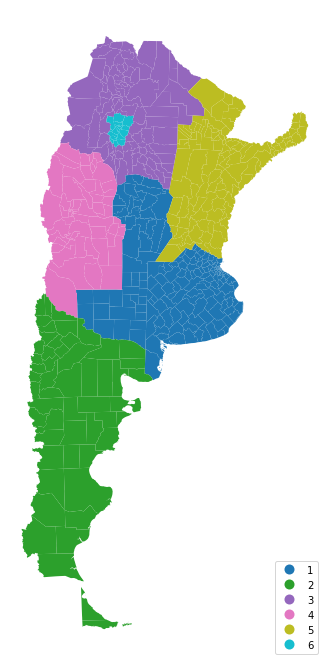

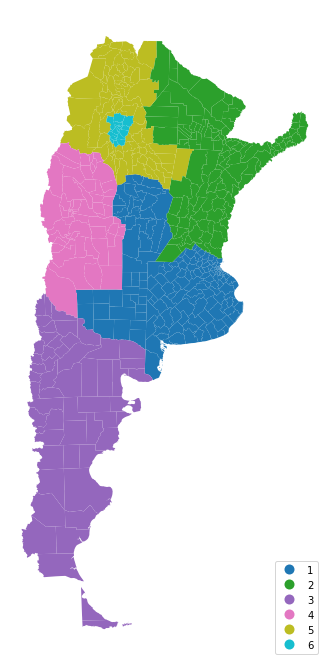

(None, None)

In [108]:
sim3.calcular_metodo('km', [['interac_porc','W','coord']], ae = False,centroides = False)
sim3.calcular_metodo('aglo', [['interac_porc','W','coord']], ae = False, centroides = False)
sim3.mapa('km'),sim3.mapa('aglo')

## Funcionamiento de autoencoders

In [116]:
sim3.crear_autoencoders(sim3.retornar_dfs(separado = [['interac_porc'],['W']]), optimizer = "sgd", loss = "cosine_similarity")
sim3.autoencoder.summary()

Model: "model_154"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_142 (InputLayer)         [(None, 231)]        0           []                               
                                                                                                  
 input_143 (InputLayer)         [(None, 525)]        0           []                               
                                                                                                  
 dense_295 (Dense)              (None, 4)            928         ['input_142[0][0]']              
                                                                                                  
 dense_296 (Dense)              (None, 4)            2104        ['input_143[0][0]']              
                                                                                          

In [118]:
from sklearn.model_selection import train_test_split

In [140]:
lista = sim3.retornar_dfs(separado = [['interac_porc'],['W']])
X1_train, X1_test = train_test_split(lista[0], test_size = 0.2, random_state = 35)
X2_train, X2_test = train_test_split(lista[1], test_size = 0.2, random_state = 35)

Minimum validation loss: -0.43661731481552124


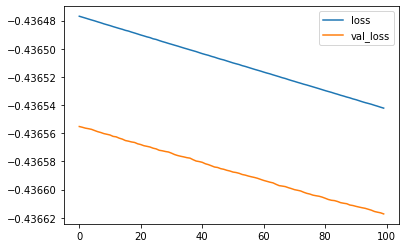

In [161]:
history = sim3.autoencoder.fit([X1_train, X2_train],np.c_[X1_train, X2_train], epochs = 100, validation_data = ([X1_test, X2_test], np.c_[X1_test, X2_test]), verbose = False) 
history = pd.DataFrame(history.history)
history.loc[:,["loss","val_loss"]].plot()
print("Minimum validation loss: {}".format(history['val_loss'].min()))

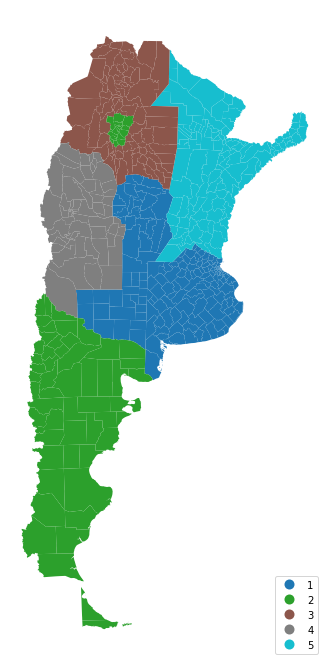

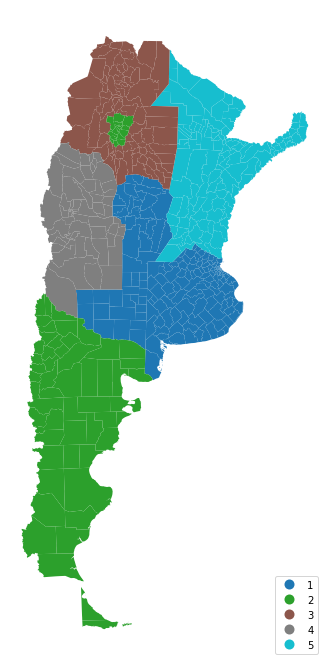

(None, None)

In [162]:
sim3.agregar_data('enco', sim3.enco.predict(lista), ajustar = False)
sim3.calcular_metodo('aglo', [['enco']], ae = False, centroides = False)
sim3.calcular_metodo('km', [['enco']], ae = False, centroides = False)
sim3.mapa('km'),sim3.mapa('aglo')

In [181]:
covid_entorno = reg.entorno( covid[['fallecido','personas','geometry']], ['fallecido'],'personas', pipe)
covid_entorno.procesar_datos()
param = {'n_clusters' : [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]} #se crean los distintos parametros para probar, en este caso solo de cantidad de grupos
metricas = {'hg': covid_entorno.metric.Hg_relat, 'ind lq': covid_entorno.metric.indice_lq} # se crean las metricas. En este caso las que provienen del LQ y es importante que salgan del entorno así buscan bien los datos
param_aglo = reg.copy(param)
param_aglo['connectivity'] = [covid_entorno.W.sparse]

covid_entorno.agregar_metodo('km', KMeans(), param, metricas)
covid_entorno.agregar_metodo('aglo', AgglomerativeClustering(), param, metricas)
covid_entorno.agregar_metodo('aglo_esp', AgglomerativeClustering(), param_aglo, metricas)


C:\Anaconda3\envs\covid2\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)
C:\Anaconda3\envs\covid2\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


In [196]:
df = covid_entorno.convertir_a_df(covid_entorno.panel_df,['fallecido'])
covid_entorno.agregar_data('prop', df['fallecido'].values/df['personas'].values.reshape(525,1))
covid_entorno.interacciones()
dato = covid_entorno.poly.fit_transform(covid_entorno.dic['prop'])
covid_entorno.agregar_data('interac_prop', dato, ajustar = False)
covid_entorno.agregar_data('W', covid_entorno.W.sparse.toarray())


Minimum validation loss: -30.513208389282227


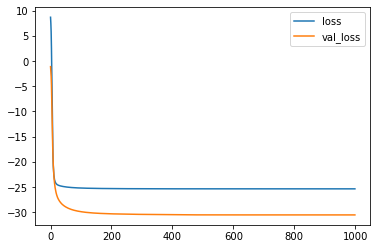

In [225]:
lista = covid_entorno.retornar_dfs(separado = [['interac_prop'],['W']])
covid_entorno.calcular_metodo('km', [['interac_prop'],['W']], ae = True, n_encoders = 4)
covid_entorno.crear_autoencoders(lista, optimizer = "adam", loss = "kl_divergence")
history = covid_entorno.autoencoder.fit(lista,np.c_[lista[0], lista[1]], epochs = 1000, validation_split = 0.2 , verbose = False) 
history = pd.DataFrame(history.history)
history.loc[:,["loss","val_loss"]].plot()
print("Minimum validation loss: {}".format(history['val_loss'].min()))


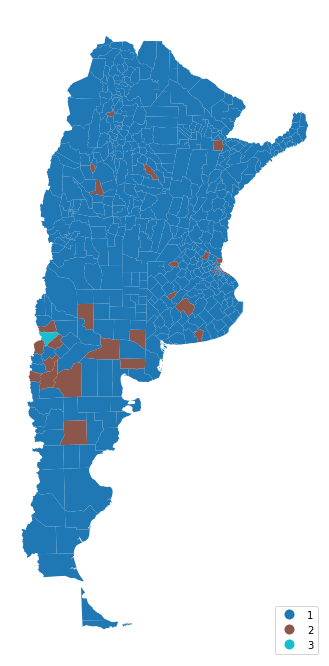

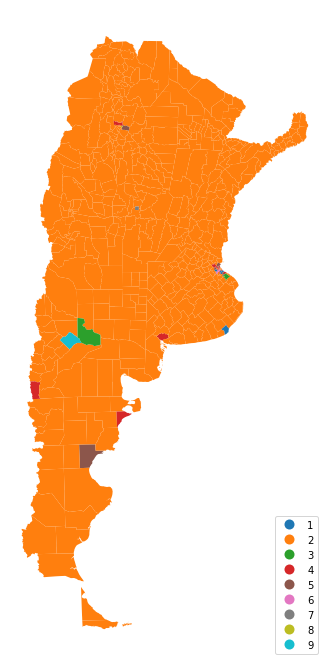

(None, None)

In [226]:
covid_entorno.agregar_data('enco', covid_entorno.enco.predict(lista), ajustar = False)
covid_entorno.calcular_metodo('aglo', [['enco']], ae = False, centroides = False)
covid_entorno.calcular_metodo('km', [['enco']], ae = False, centroides = False)
covid_entorno.mapa('km'),sim3.mapa('aglo')

In [229]:
resultados(covid_entorno)

Metodo  Vers        hg    ind lq
5         km     2  0.710562  0.131653
0         km     3  0.187074  0.235294
1         km     4  0.587198  0.156863
0         km     5  0.498947  0.294118
0         km     6  0.443005  0.235294
14        km     7  0.789694  0.072549
8         km     8  0.634770  0.216993
2         km     9  0.543333  0.186275
1         km    10  0.461826  0.294118
2         km    11  0.454108  0.215686
6         km    12  0.759112  0.107143
5         km    13  0.716356  0.126050
1         km    14  0.619563  0.333333
2       aglo     1  0.551109  0.117647
0       aglo     2  0.529134  0.235294
9       aglo     3  0.579415  0.201070
16      aglo     4  0.817977  0.086890
1       aglo     5  0.704101  0.333333
5   aglo_esp     1  0.298486  0.221289
15  aglo_esp     2  0.825908  0.145761
0   aglo_esp     3  0.498863  0.411765

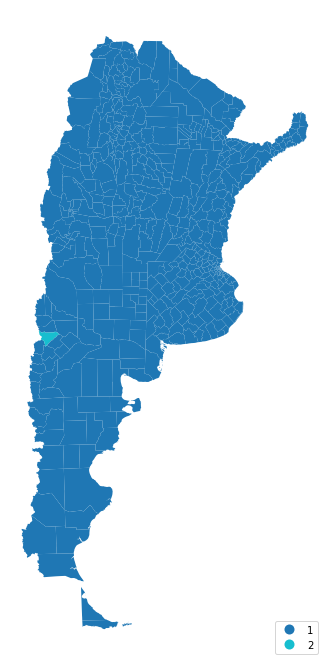

In [230]:
covid_entorno.calcular_metodo('aglo_esp', [['enco']], ae = False, centroides = False)
covid_entorno.mapa("aglo_esp")

In [231]:
resultados(covid_entorno)

Metodo  Vers        hg    ind lq
5         km     2  0.710562  0.131653
0         km     3  0.187074  0.235294
1         km     4  0.587198  0.156863
0         km     5  0.498947  0.294118
0         km     6  0.443005  0.235294
14        km     7  0.789694  0.072549
8         km     8  0.634770  0.216993
2         km     9  0.543333  0.186275
1         km    10  0.461826  0.294118
2         km    11  0.454108  0.215686
6         km    12  0.759112  0.107143
5         km    13  0.716356  0.126050
1         km    14  0.619563  0.333333
2       aglo     1  0.551109  0.117647
0       aglo     2  0.529134  0.235294
9       aglo     3  0.579415  0.201070
16      aglo     4  0.817977  0.086890
1       aglo     5  0.704101  0.333333
5   aglo_esp     1  0.298486  0.221289
15  aglo_esp     2  0.825908  0.145761
0   aglo_esp     3  0.498863  0.411765
0   aglo_esp     4  0.498863  0.411765

In [232]:
covid_entorno.autoencoder.summary()

Model: "model_188"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_177 (InputLayer)         [(None, 171)]        0           []                               
                                                                                                  
 input_178 (InputLayer)         [(None, 525)]        0           []                               
                                                                                                  
 dense_363 (Dense)              (None, 4)            688         ['input_177[0][0]']              
                                                                                                  
 dense_364 (Dense)              (None, 4)            2104        ['input_178[0][0]']              
                                                                                          

In [255]:
inp1 = reg.layers.Input(shape = [171,])
inp2 = reg.layers.Input(shape = [525,])
dense = reg.layers.Dense(150, activation = "relu",  kernel_regularizer = reg.regularizers.l2(0.01))(inp1)
dense = reg.layers.Dense(50, activation = "relu",  kernel_regularizer = reg.regularizers.l2(0.01))(dense)
dense = reg.layers.Dense(4, activation = "relu",  kernel_regularizer = reg.regularizers.l2(0.01))(dense)
espa = reg.layers.Dense(250, activation = "relu",  kernel_regularizer = reg.regularizers.l2(0.01))(inp2)
espa = reg.layers.Dense(4, activation = "relu",  kernel_regularizer = reg.regularizers.l2(0.01))(espa)
concat = reg.layers.concatenate([dense, espa])
enco = reg.layers.Dense(4, activation = "relu",  kernel_regularizer = reg.regularizers.l2(0.01))(concat)
dense = reg.layers.Dense(50, activation = "relu",  kernel_regularizer = reg.regularizers.l2(0.01))(enco)
dense = reg.layers.Dense(250, activation = "relu",  kernel_regularizer = reg.regularizers.l2(0.01))(dense)
decoder = reg.layers.Dense(696, activation = "relu",  kernel_regularizer = reg.regularizers.l2(0.01))(dense)

autoencoder = reg.Model(inputs = [inp1,inp2], outputs = decoder)
encoder = reg.Model(inputs = [inp1,inp2], outputs = enco)

Minimum validation loss: 1.007457971572876


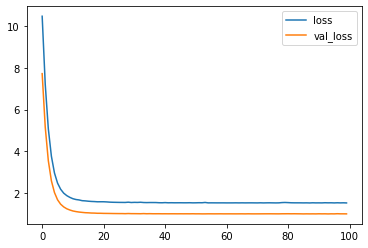

In [258]:
autoencoder.compile(optimizer = 'adam', loss = 'mse')

history = autoencoder.fit(lista,np.c_[lista[0], lista[1]], epochs = 100, validation_split = 0.2 , verbose = False) 
history = pd.DataFrame(history.history)
history.loc[:,["loss","val_loss"]].plot()
print("Minimum validation loss: {}".format(history['val_loss'].min()))


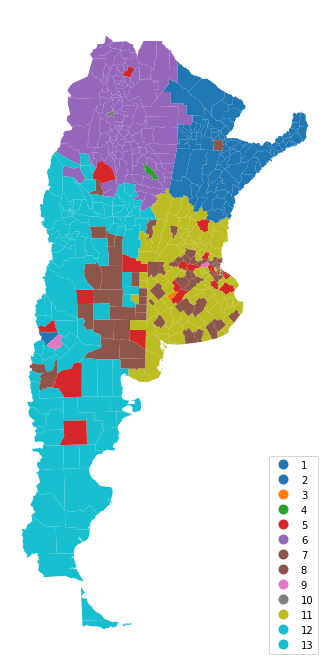

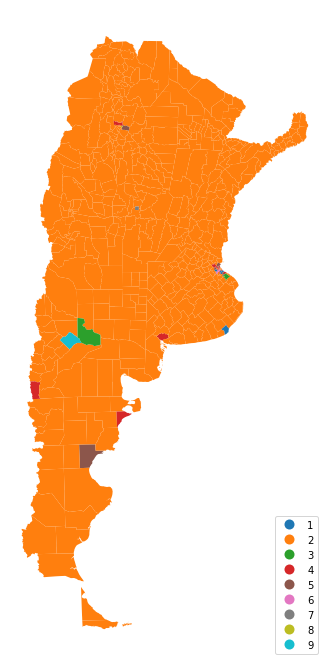

(None, None)

In [261]:
covid_entorno.agregar_data('enco', encoder.predict(lista), ajustar = False)
covid_entorno.calcular_metodo('aglo', [['enco']], ae = False, centroides = True)
covid_entorno.calcular_metodo('km', [['enco']], ae = False, centroides = True)
covid_entorno.mapa('km'),sim3.mapa('aglo')

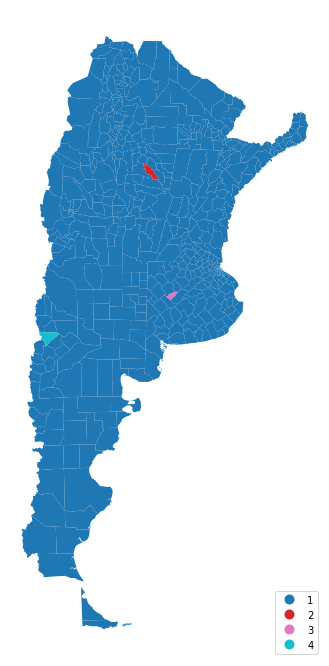

In [262]:
covid_entorno.calcular_metodo('aglo_esp', [['enco']], ae = False, centroides = True)
covid_entorno.mapa("aglo_esp")